# **Insurance Cost Prediction**

# **Problem Statement**

Insurance companies need to accurately predict the cost of health insurance for individuals to set premiums appropriately. However, traditional methods of cost prediction often rely on broad actuarial tables and historical averages, which may not adequately account for the nuanced differences among individuals. By leveraging machine learning techniques, insurers can more accurately predict insurance costs tailored to individual profiles, leading to more competitive pricing and better risk management.

# **Insurance Cost Prediction need**

The primary need for this project arises from the challenges insurers face in accurately pricing policies while remaining competitive. Inaccurate predictions can lead to losses for insurers and unfairly high premiums for policyholders. By implementing a machine learning model, insurers can:

- **Enhance Pricing Precision**: Use individual data points to determine premiums that reflect actual risk more closely than generic estimates.

- **Increase Competitiveness**: Offer rates that are attractive to consumers while ensuring the pricing is sustainable for the insurer.

- **Improve Customer Satisfaction**: Fair and transparent pricing based on personal health data can increase trust and satisfaction among policyholders.

- **Enable Personalized Offerings**: Create customized insurance packages based on predicted costs, catering more directly to the needs and preferences of individuals.

- **Strengthen Risk Assessment**: The model can be used to refine risk assessment processes, identifying key factors that most significantly influence costs.

- **Inform Policy Development**: Insights gained from the model can inform the development of new insurance products or adjustments to existing ones.

- **Aid Strategic Decision-Making**: Predictive analytics can assist in broader strategic decisions, such as entering new markets or adjusting policy terms based on risk predictions.

- **Boost Customer Engagement**: Insights from the model can be used in customer engagement initiatives, such as personalized marketing and tailored advice for policyholders.

# **Data Description**

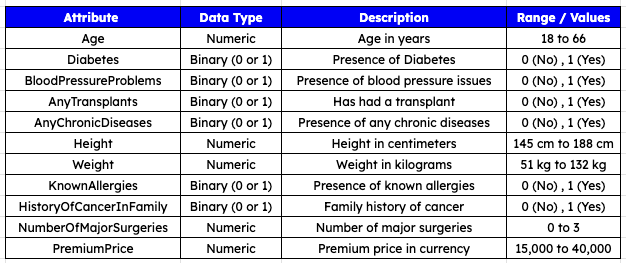

# **Reading Insurance data for Cost Prediction :**

In [1]:
# !pip install scikeras tensorflow
# !pip install --upgrade scikeras scikit-learn
# !pip install streamlit pyngrok

In [2]:
# Standard library imports
import os

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from joblib import Parallel, delayed
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf

# scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

# TensorFlow/Keras imports

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Google Colab specific
from google.colab import drive

In [3]:
# Define global color palette (used across all plots)
custom_palette = sns.color_palette("Set3")
sns.set_style("white")

In [4]:
def mount_google_drive():
    """
    Mounts the user's Google Drive to access files from Colab.
    """
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")

In [5]:
def get_data(file_path):
    """
    Reads a CSV file from the given path and returns a pandas DataFrame.

    Parameters:
    file_path (str): Full path to the CSV file on Google Drive.

    Returns:
    pd.DataFrame: The loaded data.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found at path: {file_path}")

    df = pd.read_csv(file_path)
    print(f"Data loaded successfully.")
    return df

In [6]:
def read_local_data():
    df = pd.read_csv('/content/insurance.csv')
    return df

In [7]:
try:
    # Attempt to load data from Google Drive
    mount_google_drive()
    file_path = '/content/drive/My Drive/Insurance_Data/insurance.csv'
    df = get_data(file_path)

except Exception as e:
    # If Google Drive fails, try local fallback with specific error handling
    print(f"Google Drive access failed: {str(e)}. Falling back to local data...")
    try:
        df = read_local_data()
    except Exception as local_e:
        print(f"Failed to load local data: {str(local_e)}")
        raise RuntimeError("Could not load data from either source") from local_e

# Display the first few rows if successful
display(df.head()) if 'df' in locals() else print("No data available")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Data loaded successfully.


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


# **Exploratory Data Analysis (EDA)**

In [8]:
def get_shape(df):
    """Print and return (rows, columns)."""
    shape = df.shape
    print("Shape of the dataset:")
    return shape

get_shape(df)

Shape of the dataset:


(986, 11)

In [9]:
def get_column_names(df):
    """Print and return a list of column names."""
    cols = df.columns.tolist()
    print("Column Names:")
    return cols

for col in get_column_names(df):
    print(col, end=", ")

Column Names:
Age, Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, Height, Weight, KnownAllergies, HistoryOfCancerInFamily, NumberOfMajorSurgeries, PremiumPrice, 

In [10]:
def get_data_types(df):
    """Print and return a Series of dtypes."""
    dtypes_series = df.dtypes
    dtypes_series.index.name = "Column_name"
    dtypes_series.name = "Datatype"
    return dtypes_series

get_data_types(df)

,Datatype
Column_name,
Age,int64
Diabetes,int64
BloodPressureProblems,int64
AnyTransplants,int64
AnyChronicDiseases,int64
Height,int64
Weight,int64
KnownAllergies,int64
HistoryOfCancerInFamily,int64


In [11]:
def has_missing_values(df):
    """Check if the DataFrame contains any missing values."""
    missing_exists = df.isna().any().any()
    print(f"Missing values exist: {missing_exists}")
    return missing_exists

if not has_missing_values(df):
    print("No missing values found in the dataset.")

Missing values exist: False
No missing values found in the dataset.


In [12]:
def has_duplicates(df):
    """Check if the DataFrame contains any duplicate rows."""
    duplicates_exist = df.duplicated().any()
    print(f"Duplicate records exist: {duplicates_exist}")
    return duplicates_exist

if not has_duplicates(df):
    print("No duplicate records found in the dataset.")

Duplicate records exist: False
No duplicate records found in the dataset.


In [13]:
def describe_categorical_features(df):
    """
    Displays summary statistics for all categorical columns in the dataset.
    A column is considered categorical if it has exactly 4 or less unique values.
    """
    binary_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 4]
    display(df[binary_cols].describe())

describe_categorical_features(df)

Column_name,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,0.419878,0.468560,0.055781,0.180527,0.215010,0.117647,0.667343
std,0.493789,0.499264,0.229615,0.384821,0.411038,0.322353,0.749205
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [14]:
def describe_numerical_features(df):
    """
    Displays summary statistics for all non-categorical columns in the dataset.
    A column is considered non-categorical if it has more than 4 unique values.
    """
    numeric_cols = [col for col in df.columns if df[col].nunique(dropna=True) > 4]
    display(df[numeric_cols].describe())

describe_numerical_features(df)

Column_name,Age,Height,Weight,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000
mean,41.745436,168.182556,76.950304,24336.713996
std,13.963371,10.098155,14.265096,6248.184382
min,18.000000,145.000000,51.000000,15000.000000
25%,30.000000,161.000000,67.000000,21000.000000
50%,42.000000,168.000000,75.000000,23000.000000
75%,53.000000,176.000000,87.000000,28000.000000
max,66.000000,188.000000,132.000000,40000.000000


In [15]:
def get_range(df):
    """
    Prints the min and max value of each column in the DataFrame.
    """
    col_range = pd.DataFrame({
        "min": df.min(),
        "max": df.max()
    })
    col_range.index.name = "Column"
    print("Min and Max values for numeric columns:\n")
    return col_range

get_range(df)

Min and Max values for numeric columns:



,min,max
Column,,
Age,18,66
Diabetes,0,1
BloodPressureProblems,0,1
AnyTransplants,0,1
AnyChronicDiseases,0,1
Height,145,188
Weight,51,132
KnownAllergies,0,1
HistoryOfCancerInFamily,0,1


# **Data Visualisation**

### Univariate Plots

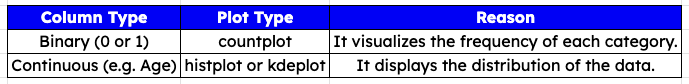


## **Univariate Analysis**

In [16]:
def plot_numeric_distribution(df, col_name, bin_size=30):
    """
    Plots the distribution of a numeric column using a histogram and KDE plot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col_name (str): The name of the numeric column to plot.
        bins (int, optional): Number of bins for the histogram. Defaults to 30.
    """
    if col_name not in df.columns:
        print(f"Error: Column '{col_name}' not found in DataFrame.")
        return

    # Create a figure and axes for the plot
    plt.figure(figsize=(10, 6))

    # Plot histogram and KDE using the custom palette
    sns.histplot(data=df, x=col_name, bins=bin_size, kde=True, edgecolor='black')

    # Add plot title and labels
    plt.title(f'Distribution of {col_name}', fontsize=12)
    plt.xlabel(col_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()



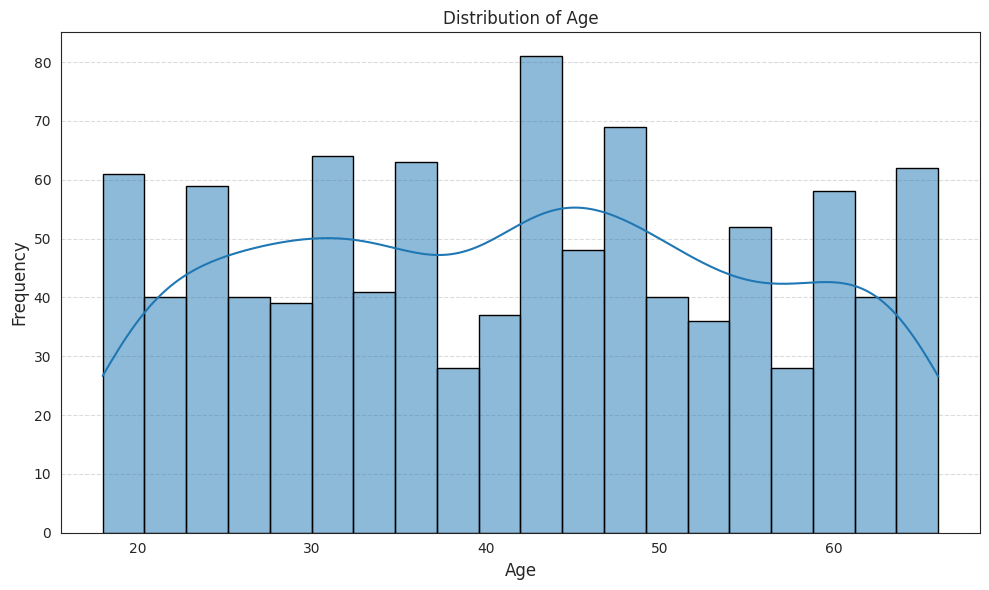

In [17]:
plot_numeric_distribution(df, col_name='Age', bin_size=20)

#### **Age distribution plot Insights**:

* The age distribution is fairly uniform across the range of 18 to 66, with slight peaks observed in the early 30s, mid-40s, and early 60s.
* No significant skew is present, indicating a balanced representation of younger, middle-aged, and older individuals in the dataset.
* The spread covers both younger and older demographics, suggesting that the dataset captures a wide age range for analysis.


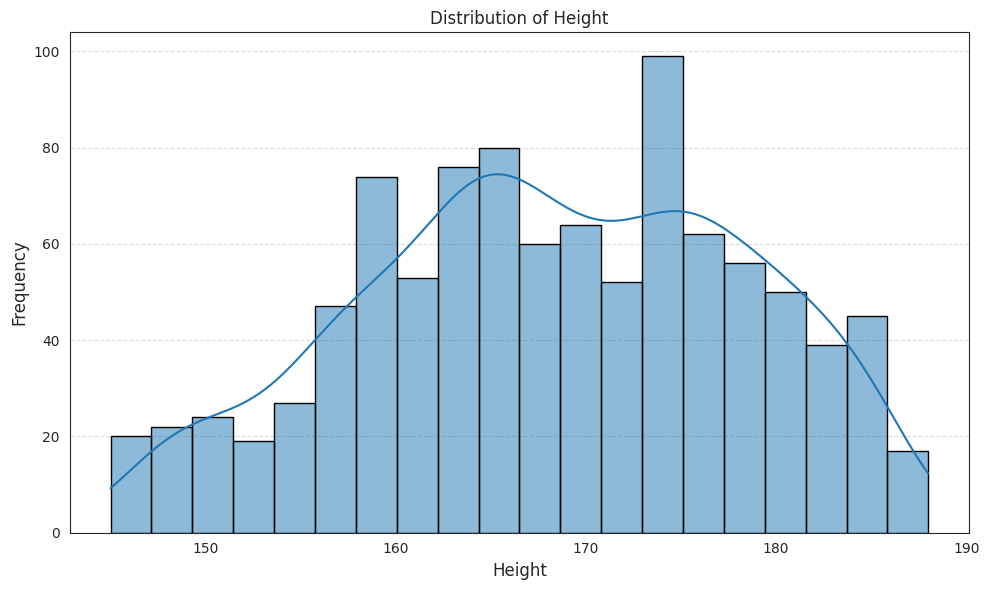

In [18]:
plot_numeric_distribution(df, col_name='Height', bin_size=20)

#### **Height distribution plot Insights**:

* Heights are concentrated between approximately 160 cm and 180 cm, with a peak around 170 cm.
* The distribution is slightly right-skewed, indicating a higher frequency of individuals in the mid-height range compared to shorter or taller extremes.
* Very short (<150 cm) and very tall (>185 cm) individuals are relatively rare in the dataset.


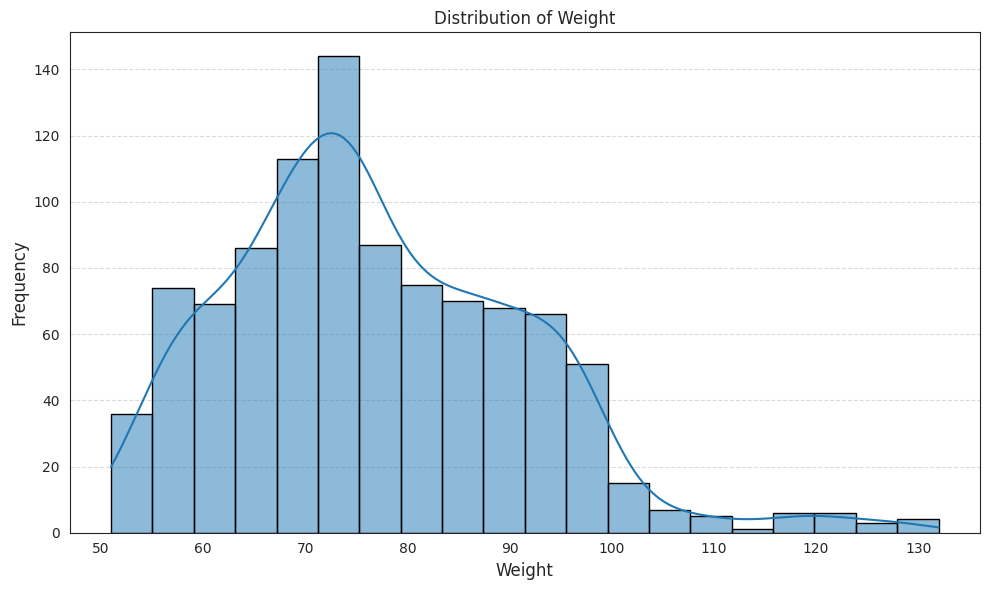

In [19]:
plot_numeric_distribution(df, col_name='Weight', bin_size=20)

#### **Weight distribution plot Insights**:

* The majority of individuals have weights between 60 kg and 90 kg, with a peak around 72–75 kg.
* The distribution is right-skewed, indicating the presence of fewer individuals with higher weights beyond 100 kg.
* Very low (`<55 kg`) and very high (`>110 kg`) weights are relatively uncommon in the dataset.


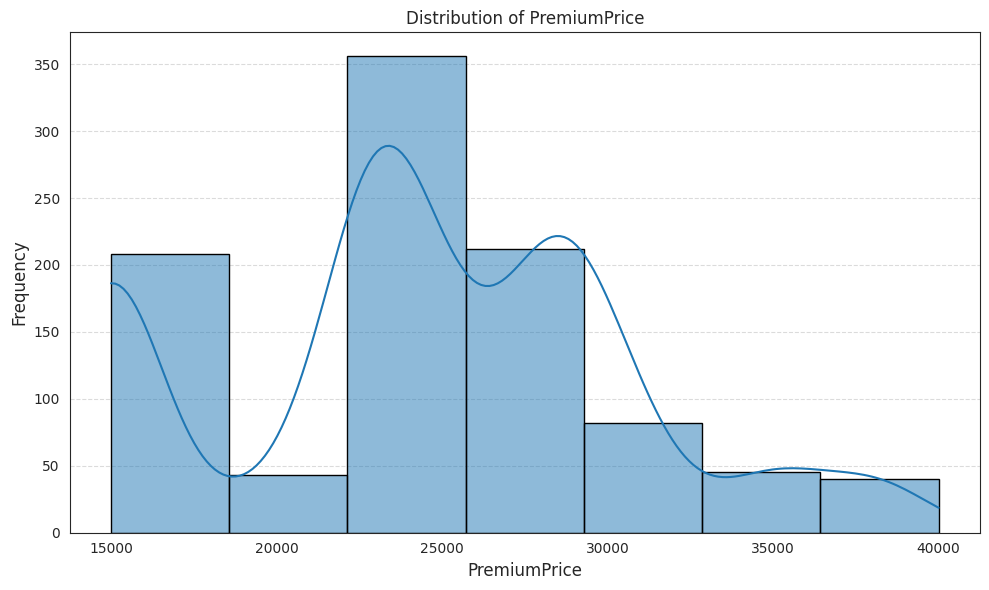

In [20]:
plot_numeric_distribution(df, col_name='PremiumPrice', bin_size=7)

#### **PremiumPrice distribution plot Insights:**

* Most premium prices fall between 22,000 and 28,000, with a notable peak around 24,000.
* There is a smaller concentration around the lower bound (15,000–18,000) and fewer high-premium cases above 32,000.
* The distribution is moderately right-skewed, indicating fewer policies with very high premium prices.


In [21]:
def plot_binary_distribution(df, column, labels_map={0: "No", 1: "Yes"}):
    """
    Plots the distribution of a categorical or binary feature using a Seaborn countplot,
    with counts displayed on top of the bars.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    column (str): The feature/column name to plot.
    labels_map (dict): Maps 0/1 binary values to readable labels (default: {0: "No", 1: "Yes"}).
    """
    # Check if column exists
    if column not in df.columns:
        print(f"Error: Column '{column}' not found in DataFrame.")
        return

    plt.figure(figsize=(8, 5))

    # Determine unique values and select corresponding colors
    unique_vals = sorted(df[column].unique())
    num_unique = len(unique_vals)
    palette_used = custom_palette[:num_unique]

    # Create the countplot
    ax = sns.countplot(
        data=df,
        x=column,
        hue=column,
        order=unique_vals,
        palette=palette_used
    )

    # Annotate bars with counts
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fontweight='bold')

    # Format title and labels
    ax.set_title(f"Distribution of {column}", fontsize=12)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

    # Add a custom legend with mapped labels if applicable
    if labels_map and num_unique == 2:
        legend_labels = [labels_map.get(val, val) for val in unique_vals]
        plt.legend(handles=ax.containers, labels=legend_labels, title="Value")

    plt.tight_layout()
    plt.show()

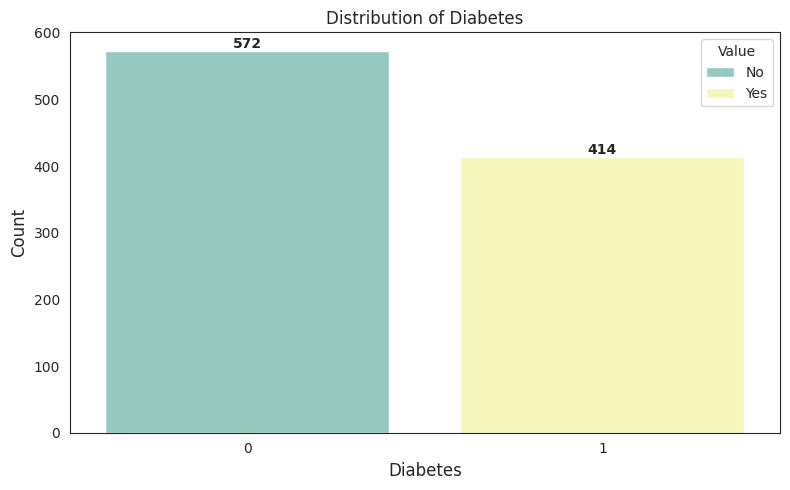

In [22]:
plot_binary_distribution(df, 'Diabetes')

#### **Diabetes distribution plot Insights**:

* A higher proportion of individuals in the dataset do not have diabetes (\~58%) compared to those who do (\~42%).
* The difference between the two groups is notable but not extreme, indicating a substantial representation of both diabetic and non-diabetic individuals.


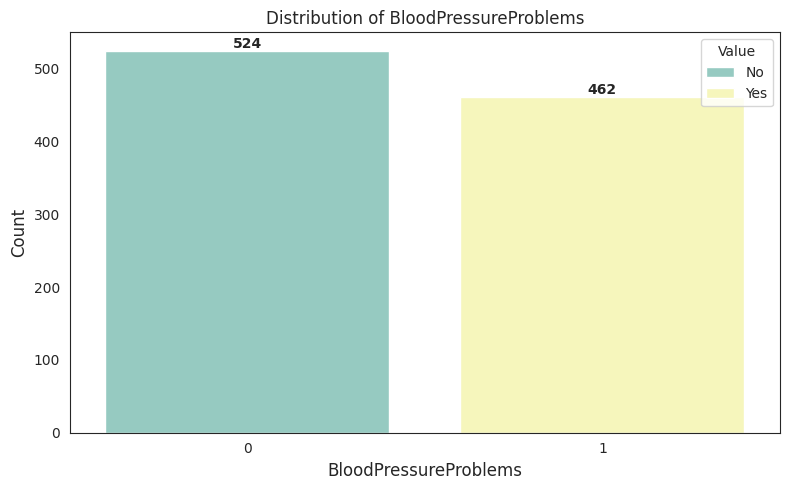

In [23]:
plot_binary_distribution(df, 'BloodPressureProblems')

#### **BloodPressureProblems distribution plot Insights:**

* Individuals without blood pressure problems make up a slightly larger portion of the dataset (\~53%) compared to those with blood pressure problems (\~47%).
* The relatively balanced distribution suggests both groups are well represented, allowing for meaningful comparisons in further analysis.


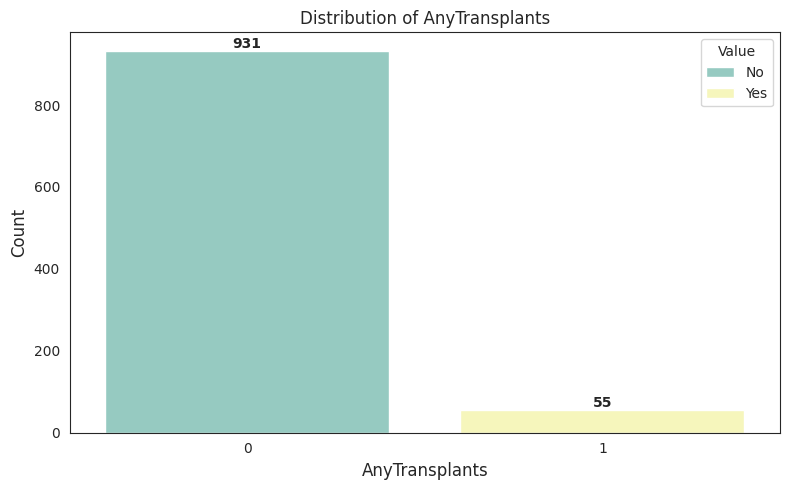

In [24]:
plot_binary_distribution(df, 'AnyTransplants')

#### **AnyTransplants distribution plot Insights:**

* A vast majority of individuals (\~94%) have not undergone any transplants, while only a small fraction (\~6%) have.
* The highly imbalanced distribution indicates that transplant cases are relatively rare in the dataset.


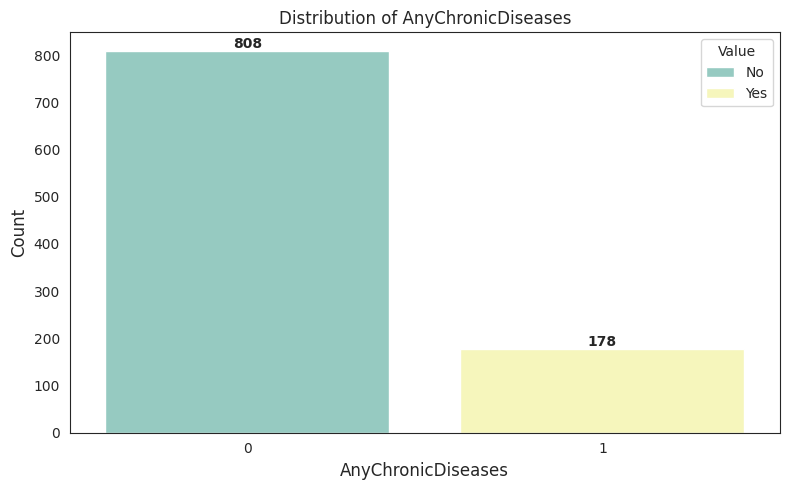

In [25]:
plot_binary_distribution(df, 'AnyChronicDiseases')

#### **AnyChronicDiseases distribution plot Insights:**

* A large majority of individuals (\~82%) do not have any chronic diseases, while a smaller proportion (\~18%) report having chronic diseases.
* The imbalance suggests that chronic disease cases are relatively less common in the dataset.


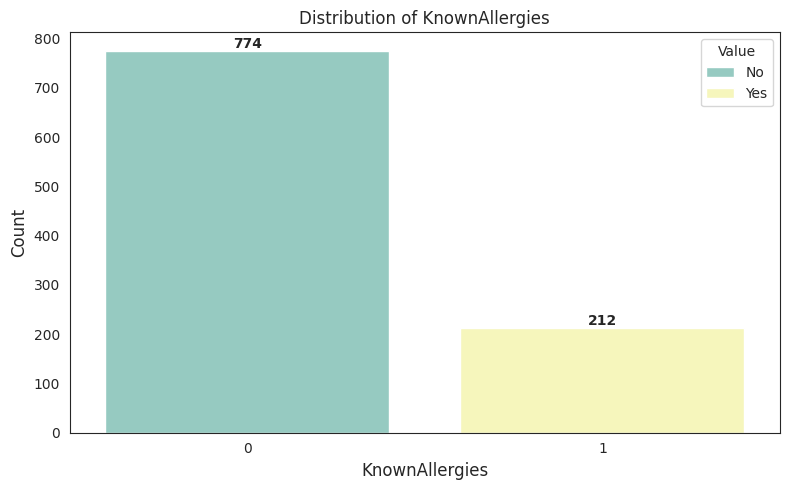

In [26]:
plot_binary_distribution(df, 'KnownAllergies')

#### **KnownAllergies distribution plot Insights:**

* The majority of individuals (\~78%) do not have known allergies, while about 22% report having them.
* The distribution indicates that allergy cases are present but notably less frequent compared to non-allergy cases in the dataset.


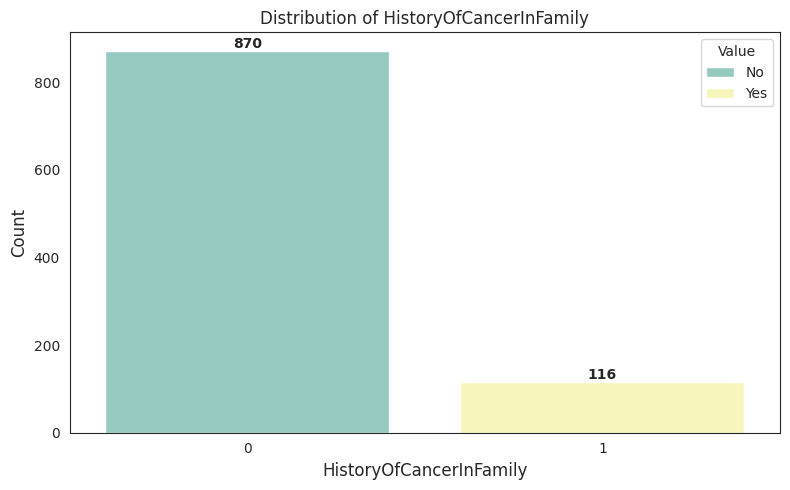

In [27]:
plot_binary_distribution(df, 'HistoryOfCancerInFamily')

#### **HistoryOfCancerInFamily distribution plot Insights:**

* An overwhelming majority of individuals (\~88%) do not have a family history of cancer, while only about 12% report such a history.
* The significant imbalance indicates that cancer family history is relatively rare in the dataset.


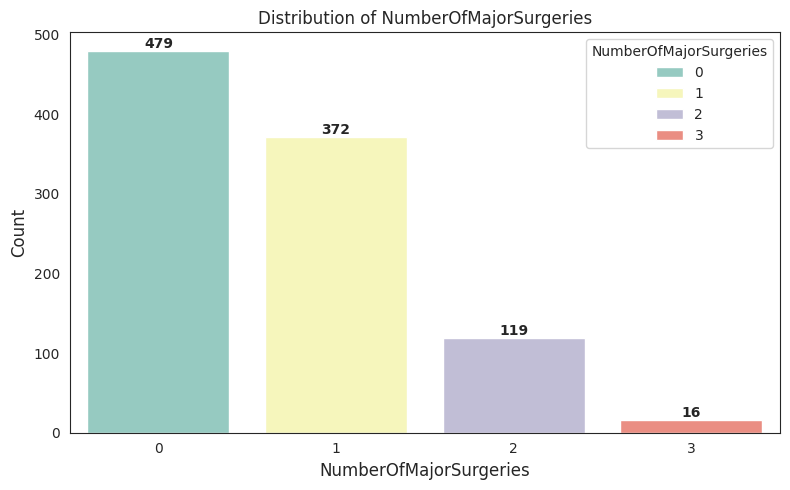

In [28]:
plot_binary_distribution(df, 'NumberOfMajorSurgeries')

#### **NumberOfMajorSurgeries distribution plot Insights:**

* Nearly half of the individuals (\~48%) have not undergone any major surgeries, while about 37% have had one surgery.
* A smaller proportion (\~12%) have undergone two surgeries, and very few (\~2%) have had three surgeries.
* The distribution is heavily skewed toward fewer surgeries, indicating that multiple major surgeries are relatively uncommon.


## **Bivariate Analysis**

### Bivariate Plots

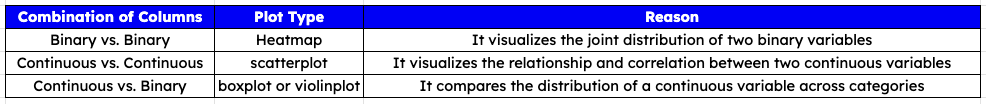

In [29]:
def plot_box_for_categorical_vs_target(df, categorical_col, target_col='PremiumPrice', labels_map={0: "No", 1: "Yes"}):
    """
    Plots a boxplot for a categorical/binary feature against a continuous target,
    mapping 0/1 to readable labels if applicable.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    categorical_col (str): The column to group by (binary or categorical).
    target_col (str): The continuous target variable (default: PremiumPrice).
    labels_map (dict): Optional label mapping for binary features.
    """
    plt.figure(figsize=(8, 5))

    unique_vals = sorted(df[categorical_col].unique())
    num_unique = len(unique_vals)
    x_col = categorical_col

    # Map labels if the column is binary and a mapping is provided
    if labels_map and num_unique == 2:
        df_plot = df.copy()
        df_plot[categorical_col] = df_plot[categorical_col].map(labels_map)
    else:
        df_plot = df

    # Create the boxplot
    sns.boxplot(
        data=df_plot,
        x=x_col,
        y=target_col,
        hue=x_col,
        palette=custom_palette[:num_unique]
    )

    # Set plot labels and title
    plt.title(f"Impact of {categorical_col} on {target_col}", fontsize=12)
    plt.xlabel(categorical_col, fontsize=12)
    plt.ylabel(target_col, fontsize=12)
    plt.tight_layout()
    plt.show()

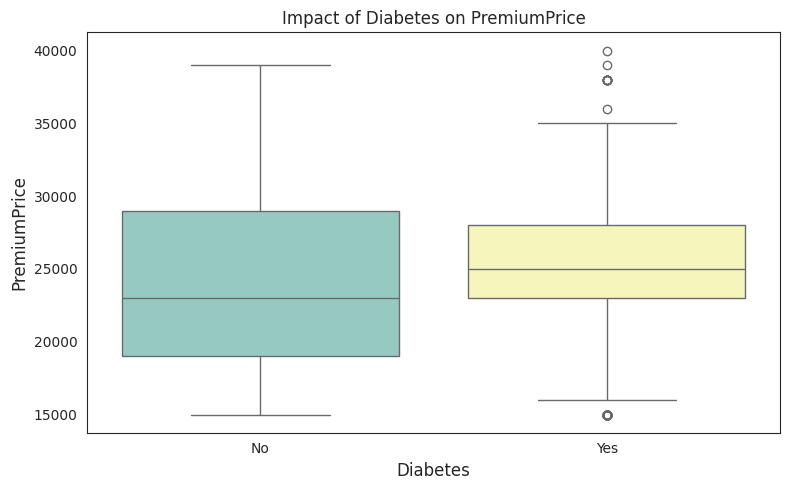

In [30]:
plot_box_for_categorical_vs_target(df, 'Diabetes')

#### **"Impact of Diabetes on PremiumPrice" plot Insights:**

* Median premium prices are slightly higher for individuals with diabetes compared to those without.
* Premium prices for both groups show a wide range, but individuals without diabetes exhibit more variability, including higher maximum values.
* Outliers are present in both groups, particularly among individuals with diabetes, indicating some unusually high premium prices in that segment.


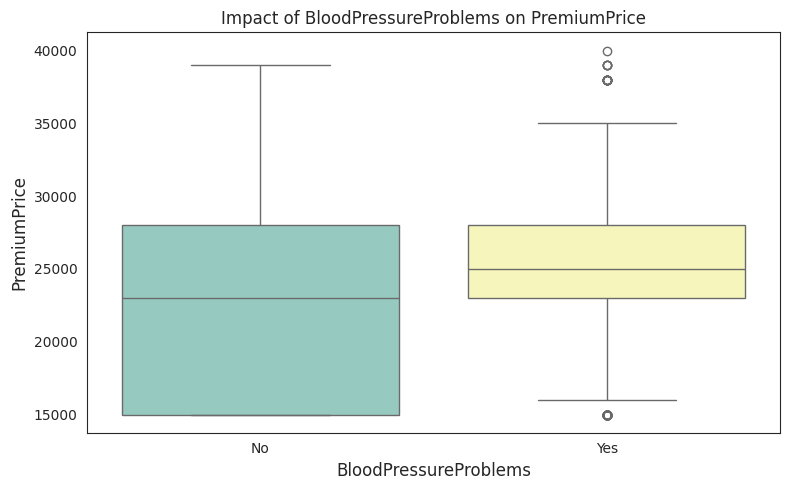

In [31]:
plot_box_for_categorical_vs_target(df, 'BloodPressureProblems')

#### **"Impact of BloodPressureProblems on PremiumPrice" plot Insights**:

* Median premium prices are higher for individuals with blood pressure problems compared to those without.
* The spread of premium prices is wider for individuals without blood pressure problems, indicating greater variability in that group.
* Several high-value outliers are observed among individuals with blood pressure problems, suggesting a subset with significantly higher premiums.


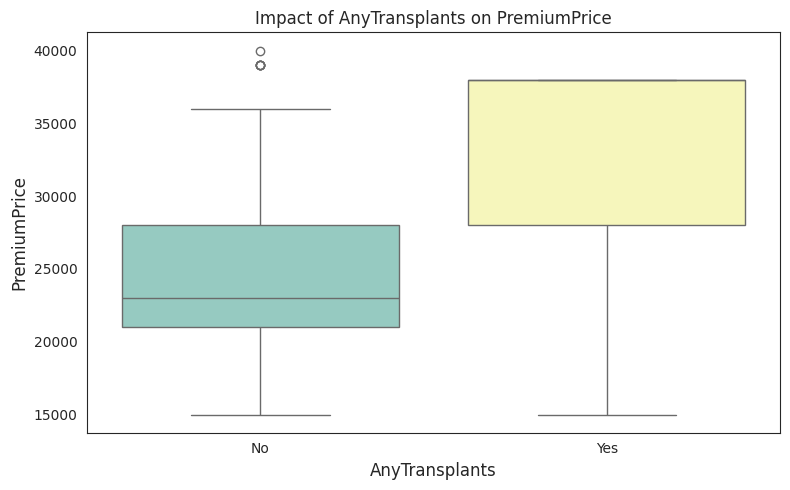

In [32]:
plot_box_for_categorical_vs_target(df, 'AnyTransplants')

#### **"Impact of AnyTransplants on PremiumPrice" plot Insights**:

* Median premium prices are noticeably higher for individuals who have undergone transplants compared to those who have not.
* The range of premium prices for transplant cases is relatively wide, though the sample size for this group may be smaller.
* Individuals without transplants show a broader spread and more outliers on the higher premium side.


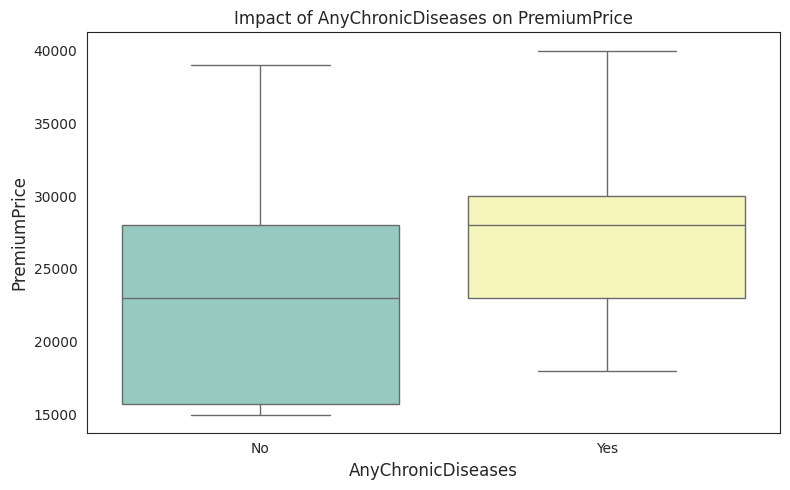

In [33]:
plot_box_for_categorical_vs_target(df, 'AnyChronicDiseases')

#### **"Impact of AnyChronicDiseases on PremiumPrice" plot Insights:**

* Median premium prices are higher for individuals with chronic diseases compared to those without.
* The premium price range is broader for individuals with chronic diseases, indicating greater variability in costs for this group.


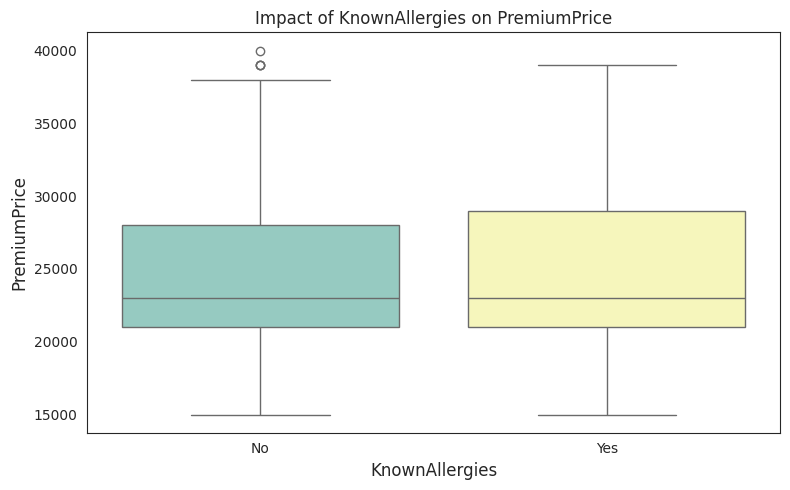

In [34]:
plot_box_for_categorical_vs_target(df, 'KnownAllergies')

#### **"Impact of KnownAllergies on PremiumPrice" plot Insights:**

* Median premium prices are similar for individuals with and without known allergies, indicating that allergies may not strongly influence premiums.
* Both groups show a comparable range of premium prices, with overlapping interquartile ranges.
* Outliers exist in both categories, suggesting a few cases with unusually high premiums regardless of allergy status.


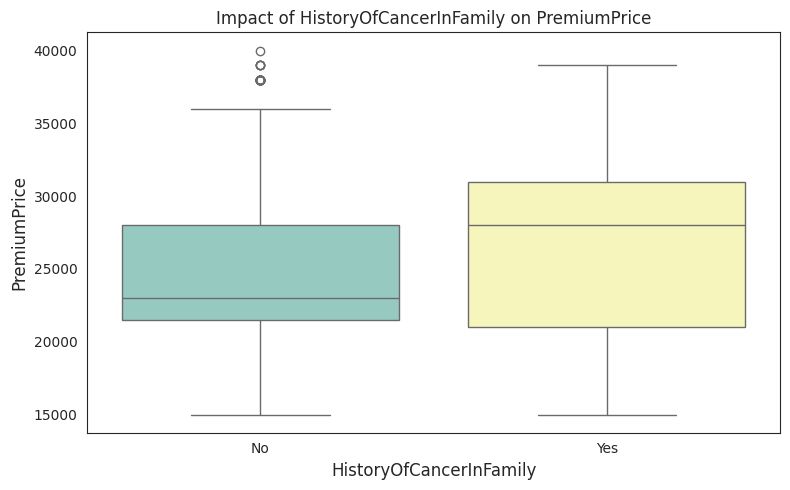

In [35]:
plot_box_for_categorical_vs_target(df, 'HistoryOfCancerInFamily')

#### **"Impact of HistoryOfCancerInFamily on PremiumPrice" plot Insights:**

* Median premium prices are higher for individuals with a family history of cancer compared to those without.
* The spread of premium prices is broader for individuals with a family history, indicating greater variability in this group.
* Outliers are more prominent among individuals without a family history of cancer, showing some unusually high premium values in that category.


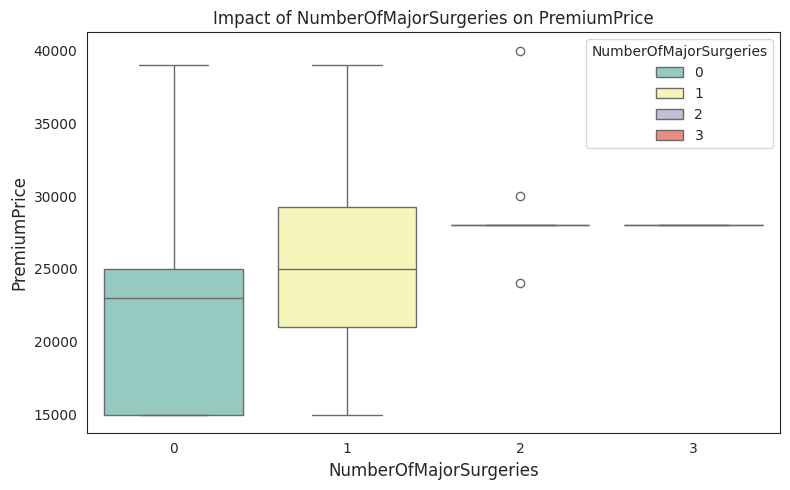

In [36]:
plot_box_for_categorical_vs_target(df, 'NumberOfMajorSurgeries')

#### **"Impact of NumberOfMajorSurgeries on PremiumPrice" plot Insights:**

* Median premium prices tend to increase slightly with the number of major surgeries, particularly for individuals with one surgery compared to none.
* Premium prices for individuals with two or three surgeries appear similar, though these groups have smaller sample sizes.
* The widest variation in premium prices is observed among individuals with zero or one surgery, while higher surgery counts show more clustered values.


In [37]:
def plot_continuous_relationship(df, feature_col, target_col='PremiumPrice'):
    """
    Plots a regression plot between a continuous feature and the target variable
    to visualize their relationship and trend.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    feature_col (str): The continuous feature column name.
    target_col (str): The continuous target variable (default: PremiumPrice).
    """
    plt.figure(figsize=(8, 5))
    ax = sns.regplot(data=df, x=feature_col, y=target_col, line_kws={'color': 'red'})

    ax.set_title(f"Relationship: {target_col} vs {feature_col}", fontsize=12)
    ax.set_xlabel(feature_col, fontsize=12)
    ax.set_ylabel(target_col, fontsize=12)

    # Add grid
    ax.grid(True, linestyle='-', alpha=0.6)

    plt.tight_layout()
    plt.show()

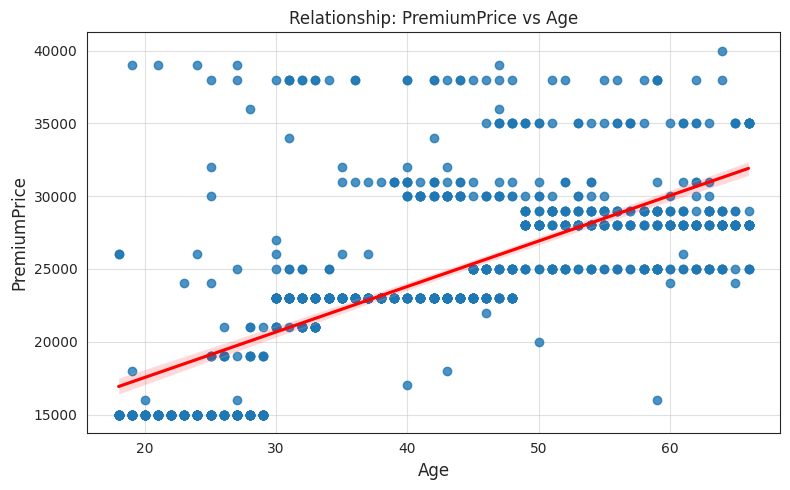

In [38]:
plot_continuous_relationship(df, feature_col='Age')


#### **"PremiumPrice vs Age" relationship plot Insights**:

* There is a positive correlation between age and premium price, indicating that older individuals tend to have higher premiums.
* While the upward trend is clear, there is notable variation in premium prices across all age groups, suggesting that other factors also influence pricing.
* Premium prices for younger individuals are generally lower, with fewer cases reaching the higher premium range compared to older age groups.


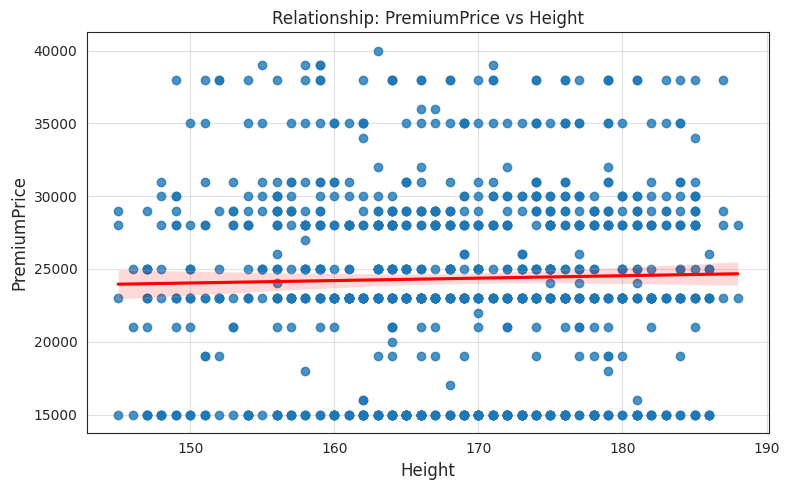

In [39]:
plot_continuous_relationship(df, feature_col='Height')


#### **"PremiumPrice vs Height" relationship plot Insights:**

* There is no strong correlation between height and premium price, as indicated by the nearly flat trend line.
* Premium prices are distributed across a wide range for all height values, suggesting that height alone is not a major determinant of premium pricing.
* The data points are widely scattered, indicating substantial variability in premiums for individuals of similar heights.


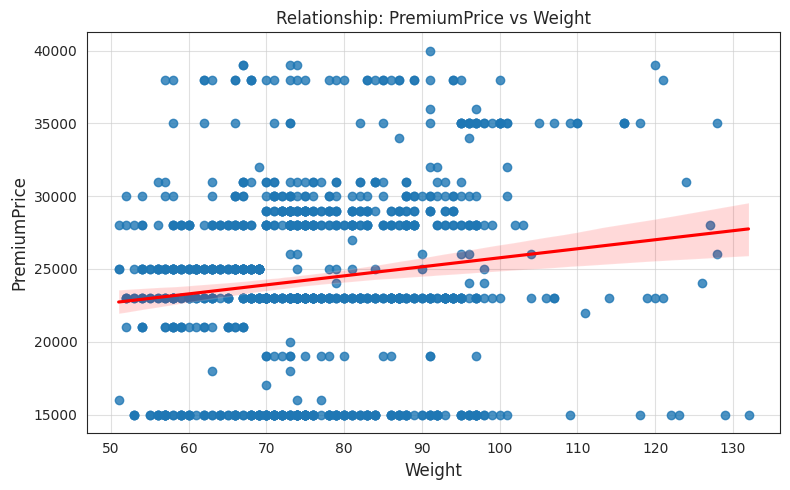

In [40]:
plot_continuous_relationship(df, feature_col='Weight')


**PremiumPrice vs Weight relationship plot Insights:**

* There is a slight positive correlation between weight and premium price, indicating that higher weights are generally associated with slightly higher premiums.
* The scatter is widely spread for most weight ranges, suggesting that weight alone does not strongly determine premium pricing.
* Premium prices above 30,000 are observed across various weight values, not concentrated in a specific weight range.


# **Feature Engineering**

In [41]:
def add_bmi_feature(df):
    """
    Adds a BMI (Body Mass Index) column to the dataframe using height in cm and weight in kg.

    Parameters:
    df (pd.DataFrame): Input dataframe with 'Height' (in cm) and 'Weight' (in kg)

    Returns:
    pd.DataFrame: Updated dataframe with new 'BMI' column
    """
    df = df.copy()
    df['Height_m'] = df['Height'] / 100  # Convert height to meters
    df['BMI'] = df['Weight'] / (df['Height_m'] ** 2)
    df.drop(columns=['Height_m', 'Height', 'Weight'], inplace=True)
    return df

# Create a new dataframe with Feature Enginnering
df_with_bmi = add_bmi_feature(df)
display(df_with_bmi)

Column,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,45,0,0,0,0,0,0,0,25000,23.725286
1,60,1,0,0,0,0,0,0,29000,22.530864
2,36,1,1,0,0,0,0,1,23000,23.634033
3,52,1,1,0,1,0,0,2,28000,27.770313
4,38,0,0,0,1,0,0,1,23000,31.934969
...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,0,0,0,15000,23.458562
982,64,1,1,0,0,0,0,3,28000,29.903029
983,56,0,1,0,0,0,0,1,29000,29.552549
984,47,1,1,0,0,1,0,1,39000,29.242109


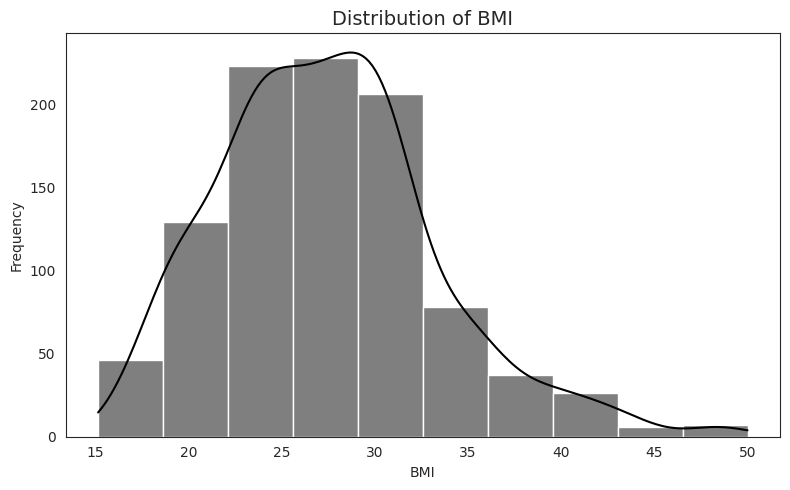

In [42]:
def plot_bmi_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df['BMI'], color='black', kde=True, bins=10)
    plt.title("Distribution of BMI", fontsize=14)
    plt.xlabel("BMI")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_bmi_distribution(df_with_bmi)

### **BMI Distribution Insights:**

The BMI distribution is right-skewed, with most values between 20–32 and a peak around 25–28, while extreme low (<18.5) and high (>40) BMIs are rare.


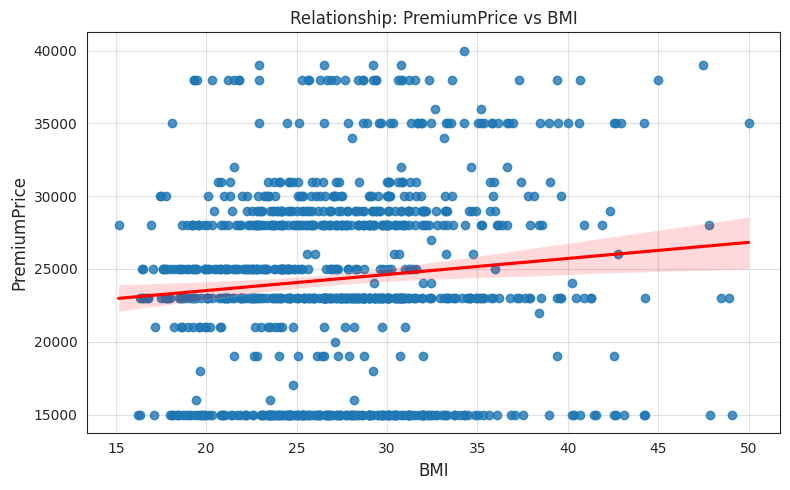

In [43]:
plot_continuous_relationship(df_with_bmi, 'BMI')

**Insights for the PremiumPrice vs BMI relationship plot:**

PremiumPrice shows a slight upward trend with increasing BMI, though the data is widely scattered, indicating a weak positive relationship.


# **Correlation Analysis**

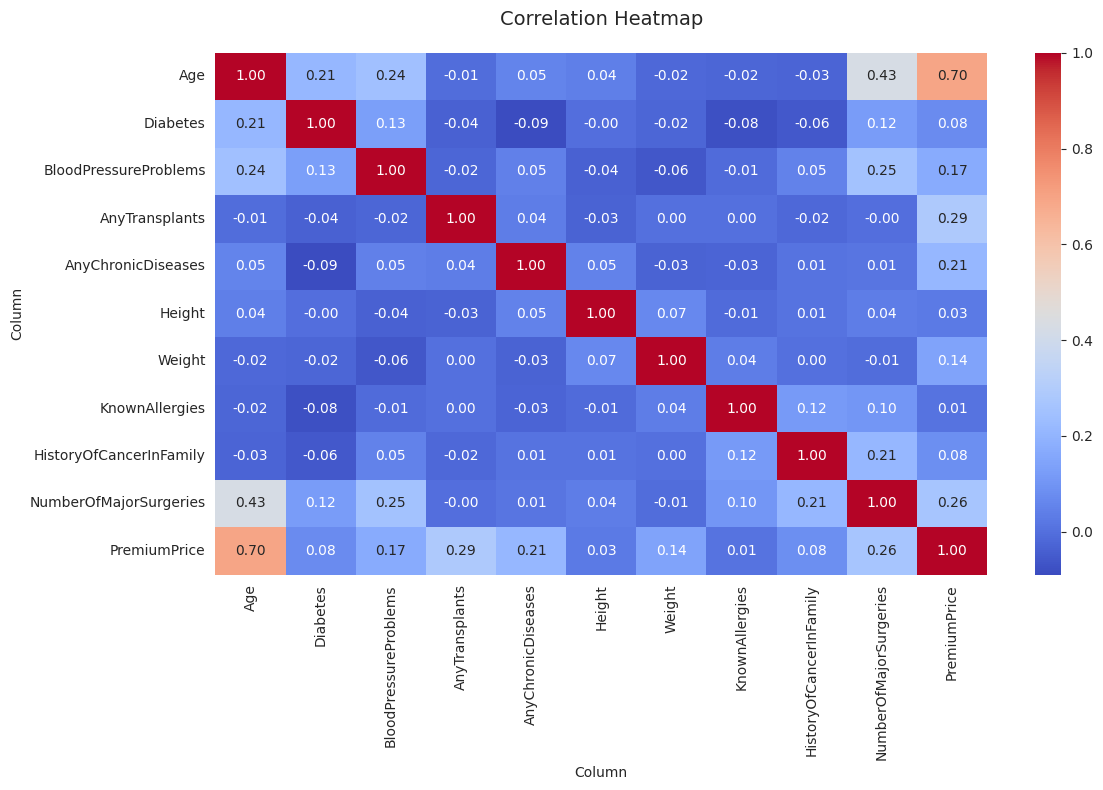

In [44]:
def plot_correlation(df, figsize=(12, 8), annot=True, cmap='coolwarm', fmt=".2f"):
    """
    Plots a correlation heatmap for all numerical variables in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing numerical features.
    figsize (tuple): Size of the figure (width, height).
    annot (bool): Whether to display correlation values on the heatmap.
    cmap (str): Color palette to use for the heatmap.
    fmt (str): Format string for annotations (default ".2f" for 2 decimal places).
    """
    plt.figure(figsize=figsize)
    corr_matrix = df.corr(numeric_only=True)

    ax = sns.heatmap(
        corr_matrix,
        annot=annot,
        cmap=cmap,
        fmt=fmt
    )

    ax.set_title("Correlation Heatmap", fontsize=14, pad=20)
    plt.xticks()
    plt.tight_layout()
    plt.show()

# Example usage
plot_correlation(df)

### **Top Correlated Predictors with PremiumPrice**

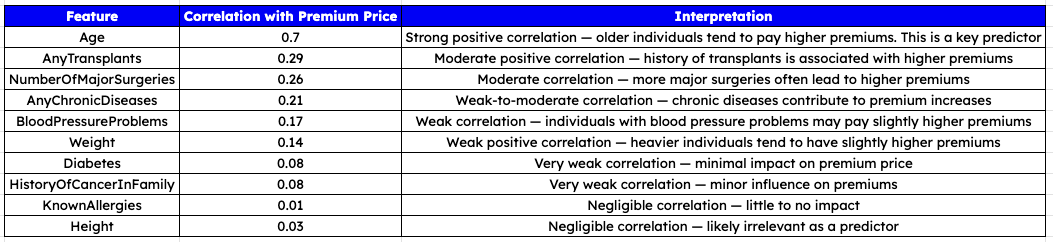

### **Actionable Insights for Modeling**

* **Strongest predictors:**

  * `Age`
  * `AnyTransplants`
  * `NumberOfMajorSurgeries`
* **Moderate contributors:**

  * `AnyChronicDiseases`
  * `BloodPressureProblems`
* **Low or negligible impact:**

  * `Height`, `KnownAllergies`, `HistoryOfCancerInFamily`


# **Outlier Detection**

### **Why Outlier Detection is Performed on Continuous Variables?**

Outlier detection was applied exclusively to **continuous variables** like `Age`, `Height`, `Weight`, `BMI`, and `PremiumPrice`, and **not** to categorical variables such as `Diabetes`, `KnownAllergies`, or `AnyChronicDiseases`. This decision was both deliberate and correct for the following reasons:

#### 1. **Categorical Data Lacks Statistical "Spread"**

Categorical variables represent **distinct groups or labels**, not numerical quantities.  Their values (e.g., 0, 1) are merely codes for categories like "No" or "Yes." Outlier detection methods, such as the **IQR** or **Z-score**, are fundamentally based on a variable's distribution and distance from a central point (mean or median). Since categorical data doesn't have a meaningful distribution in this sense, these methods are not applicable.

#### 2. **Low Frequency is Not an Outlier**

An infrequent category (e.g., a small number of people with `AnyTransplants`) is a **valid and important part of the data**, not an anomaly. Treating a minority class as an outlier would be a misclassification. These instances are crucial to understanding the full scope of the population. Removing or altering them would introduce significant bias and compromise the dataset's integrity.

#### 3. **Preserving Critical Predictive Signals**

These rare categories often carry **strong predictive power**. For example, having a rare chronic disease may be a key factor in predicting `PremiumPrice`. Dropping these instances would weaken the model's ability to learn important relationships and make accurate predictions.

#### 4. **Addressing Imbalance with Appropriate Methods**

If a class imbalance in categorical features needs to be addressed for modeling purposes, techniques designed specifically for this purpose are used. Methods like **oversampling (e.g., SMOTE)** or **class weighting** are far more suitable than outlier detection, as they preserve the integrity of the data while helping the model learn from minority classes.

**Conclusion**: Outlier detection is a tool for identifying statistical anomalies in continuous data. For categorical features, every value—regardless of its frequency—is a valid data point that must be preserved to ensure data integrity and model accuracy.

In [45]:
def get_outliers(df, threshold=1.5):
    """
    Detect outliers in numerical columns using the IQR method.

    Parameters:
    - df: pandas DataFrame containing numerical columns
    - threshold: IQR multiplier for detecting outliers (default=1.5)

    Returns:
    - outliers_dict: dictionary with column name as key and list of outlier values as values
    """
    outliers_dict = {}
    numeric_cols = ['Age', 'Weight', 'Height', 'PremiumPrice']

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outlier_values = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].tolist()
        outliers_dict[col] = outlier_values

    return outliers_dict

outliers = get_outliers(df)

for col, values in outliers.items():
    unique_vals = np.unique(values)
    if len(unique_vals) > 0:
        print(f"{col} — {len(unique_vals)} unique outliers: All values greater than {min(unique_vals)}")
    else:
        print(f"{col} has no outliers.")

Age has no outliers.
Weight — 12 unique outliers: All values greater than 118
Height has no outliers.
PremiumPrice — 2 unique outliers: All values greater than 39000


In [46]:
def plot_outlier_boxplot(df: pd.DataFrame, column: str):
    """
    Plots a horizontal boxplot for a single numerical column to visualize outliers.

    Parameters:
    - df (pd.DataFrame): The input pandas DataFrame.
    - column (str): The name of the numerical column to plot.
    """
    if column not in df.columns:
        print(f"Error: Column '{column}' not found in DataFrame.")
        return

    plt.figure(figsize=(8, 1.5))
    ax = sns.boxplot(x=df[column], color='gray')

    ax.set_title(f'Boxplot of {column}', fontsize=12)
    ax.set_xlabel(column)

    plt.tight_layout()
    plt.show()

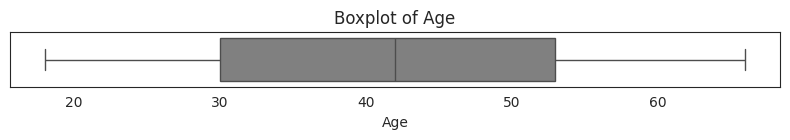

In [47]:
plot_outlier_boxplot(df, 'Age')

**Insights for the Age boxplot with a focus on outliers:**

* The boxplot shows no visible outliers, as all data points fall within the whiskers.
* The age distribution is fairly symmetric, with values ranging approximately from 18 to 66 years.
* Since there are no extreme values, no outlier treatment is required for this variable.


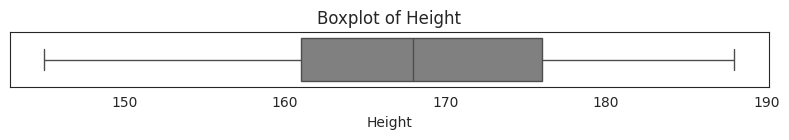

In [48]:
plot_outlier_boxplot(df, 'Height')

**Insights for the Height boxplot with a focus on outliers:**

* The boxplot indicates no outliers, as all height values lie within the whiskers.
* Heights range from approximately 145 cm to 188 cm, with most values concentrated between about 160 cm and 176 cm.
* Since no extreme values are detected, no outlier treatment is necessary for this variable.


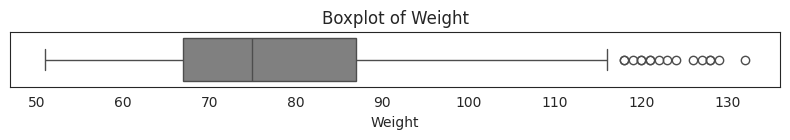

In [49]:
plot_outlier_boxplot(df, 'Weight')

**Insights for the Weight boxplot with a focus on outliers:**

* Several outliers are present on the higher end, with weights exceeding approximately 115 kg.
* The majority of weights fall between roughly 65 kg and 115 kg, with a median around 75–80 kg.
* These high-value outliers may warrant further investigation to determine if they are valid data points or anomalies.


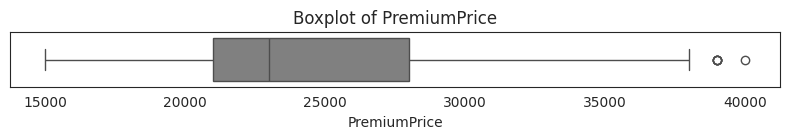

In [50]:
plot_outlier_boxplot(df, 'PremiumPrice')

**Insights for the PremiumPrice boxplot with a focus on outliers:**

* A few high-value outliers are present, with premiums exceeding approximately 38,000.
* Most premium prices range between about 21,000 and 37,000, with a median around 24,000.
* The presence of outliers suggests some individuals are paying significantly higher premiums than the general population.


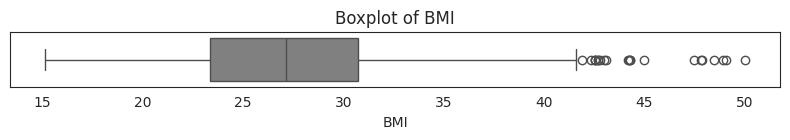

In [51]:
plot_outlier_boxplot(df_with_bmi, 'BMI')

Insights based on BMI:

- Heavy outliers exist above BMI 40.

- Skewed toward the right — higher BMI individuals are few but influential.

- May require special treatment due to potential medical relevance.

### **Justification for Retaining Outliers**

During exploratory data analysis, outliers were identified in continuous variables such as **`Weight`** and **`PremiumPrice`** using the Interquartile Range (IQR) method. These values were **intentionally retained** rather than being removed or capped, based on the following key considerations:

#### **Small Dataset Size**
With only 986 records, the dataset is relatively small. Removing or capping outliers could lead to a significant loss of valuable data. Each record is meaningful for the learning process, and reducing the dataset size further could negatively impact the model's ability to generalize.

#### **Informative Nature of Outliers**
In insurance, outliers often represent **genuine, high-risk cases** rather than data errors. For example, an exceptionally high `Weight` or `BMI` is a valid indicator of a higher health risk, which directly influences the `PremiumPrice`. Removing these values would prevent the model from learning to associate these important risk factors with higher costs.

#### **Real-World Generalization**
Real-world insurance datasets naturally contain extreme values. Excluding this data would create a model that performs well only on "average" cases but is **ill-equipped to handle the high-risk profiles** it would encounter in a production environment. Retaining outliers ensures the model can generalize to the full spectrum of real-world scenarios.

#### **Model Robustness**
The chosen machine learning algorithms, such as **Random Forests** and **XGBoost**, are known to be inherently robust to outliers. They are less sensitive to extreme values than linear models and can effectively learn patterns without being unduly influenced by them.



**Conclusion:** The decision to keep the outliers was made to **preserve data integrity** and ensure the model can learn from all genuine cases. This approach maintains the informative variation in the data, leading to a more robust model that is better equipped to handle real-world insurance profiles.

# **Hypothesis Testing**

## **Summary: Choosing the Right Statistical Test**

| **Test** | **Independent Variable (X)** | **Dependent Variable (Y)** | **Used When** | **Goal** |
| :--- | :--- | :--- | :--- | :--- |
| **T-Test** | Categorical (2 groups) | Continuous | You want to **compare the means** of two distinct groups. | Determine if there is a significant difference between two group means. |
| **ANOVA** | Categorical ($>2$ groups) | Continuous | You want to **compare the means** across three or more groups. | Detect if at least one group mean is different from the others. |
| **Chi-Square** | Categorical | Categorical | You want to test if there is a **significant association** between two categorical variables. | Assess the dependence or independence of two categorical variables. |
| **Correlation** | Continuous | Continuous | You want to measure the **strength and direction** of a linear relationship between two variables. | Quantify the relationship, but not causality. |
| **Regression** | Continuous / Categorical | Continuous | You want to **predict** a continuous outcome using one or more variables. | Build a predictive model to explain an outcome. |



## **Quick Examples:**

| Scenario | Test to Use |
| :--- | :--- |
| Compare the average premium between diabetic and non-diabetic users. | **T-Test** |
| Compare the average premium across three BMI categories (e.g., underweight, normal, obese). | **ANOVA** |
| Check if having diabetes is associated with having allergies. | **Chi-Square** |
| Measure the strength of the relationship between `Age` and `PremiumPrice`. | **Correlation** |
| Predict `PremiumPrice` based on `Age`, `BMI`, and `HasChronicDiseases`. | **Regression** |



### **Notes:**

* Use **T-test/ANOVA** to compare the **means** of continuous data across groups.
* Use **Chi-square** to assess **association** between categorical variables.
* Use **Correlation** to measure the **relationship** between two continuous variables.
* Use **Regression** for **prediction** and explanatory modeling of a continuous outcome.

### **Comparing means of `PremiumPrice` across groups defined by categorical features**


| Categorical Variable      | Unique Values | Test Type |
| ------------------------- | ------------- | --------- |
| `Diabetes`                | 2             | t-test    |
| `BloodPressureProblems`   | 2             | t-test    |
| `AnyTransplants`          | 2             | t-test    |
| `AnyChronicDiseases`      | 2             | t-test    |
| `KnownAllergies`          | 2             | t-test    |
| `HistoryOfCancerInFamily` | 2             | t-test    |
| `NumberOfMajorSurgeries`  | 4             | **ANOVA** |



In [52]:
def perform_ttest(df: pd.DataFrame, cat_col: str, target_col: str = 'PremiumPrice'):
    """
    Performs an independent t-test between two groups of a categorical variable.

    H0: The mean of the target_col is the same across the two groups.
    H1: The mean of the target_col is significantly different between the two groups.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - cat_col (str): The categorical column with exactly two unique values.
    - target_col (str): The continuous target column.
    """
    # 1. Input Validation and Data Preparation
    if cat_col not in df.columns or target_col not in df.columns:
        print(f"Error: One or both columns ('{cat_col}', '{target_col}') not found in DataFrame.")
        return

    groups = df[cat_col].dropna().unique()
    if len(groups) != 2:
        print(f"Error: '{cat_col}' must have exactly 2 unique categories for a t-test. Found: {len(groups)}")
        return

    # 2. Separate data into two groups
    group1 = df[df[cat_col] == groups[0]][target_col]
    group2 = df[df[cat_col] == groups[1]][target_col]

    # 3. Print test summary and perform the t-test
    print(f"\n--- Independent t-test: {target_col} by {cat_col} ---")
    print(f"Group 1 ('{groups[0]}') mean: {group1.mean():.2f}")
    print(f"Group 2 ('{groups[1]}') mean: {group2.mean():.2f}")
    print("H₀: Mean premium is the same for both groups.")
    print("H₁: Mean premium is different between the groups.")

    stat, p = ttest_ind(group1, group2, equal_var=False)  # Use Welch's t-test by default

    print(f"Test Statistic = {stat:.4f}")
    print(f"P-value        = {p:.4f}")

    # 4. Conclude based on the p-value
    alpha = 0.05
    if p < alpha:
        print(f"Conclusion     : Statistically significant difference (P < {alpha}). Reject H₀.")
    else:
        print(f"Conclusion     : No significant difference (P ≥ {alpha}). Fail to reject H₀.")

In [53]:
def perform_anova(df: pd.DataFrame, cat_col: str, target_col: str = 'PremiumPrice'):
    """
    Performs a one-way ANOVA test for a categorical variable with multiple groups.

    H0: The mean of the target_col is the same across all groups.
    H1: At least one group has a significantly different mean.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - cat_col (str): The categorical column with three or more unique values.
    - target_col (str): The continuous target column.
    """
    # 1. Input Validation and Data Preparation
    if cat_col not in df.columns or target_col not in df.columns:
        print(f"Error: One or both columns ('{cat_col}', '{target_col}') not found in DataFrame.")
        return

    groups = df[cat_col].dropna().unique()
    if len(groups) < 3:
        print(f"Error: '{cat_col}' must have 3 or more unique categories for ANOVA. Found: {len(groups)}")
        return

    # 2. Separate data into groups for ANOVA
    group_data = [df[df[cat_col] == g][target_col].dropna() for g in groups]

    # 3. Print test summary and perform the ANOVA test
    print(f"\n--- ANOVA Test: {target_col} by {cat_col} ---")
    print(f"Groups tested: {', '.join(str(g) for g in groups)}")
    print("H₀: All group means for premium are the same.")
    print("H₁: At least one group mean is different.")

    stat, p = f_oneway(*group_data)

    print(f"F-Statistic    = {stat:.4f}")
    print(f"P-value        = {p:.4f}")

    # 4. Conclude based on the p-value
    alpha = 0.05
    if p < alpha:
        print(f"Conclusion     : Statistically significant difference (P < {alpha}). Reject H₀.")
        print("Note: At least one group's mean is different.")
    else:
        print(f"Conclusion     : No significant difference (P ≥ {alpha}). Fail to reject H₀.")

In [54]:
perform_ttest(df, 'Diabetes')



--- Independent t-test: PremiumPrice by Diabetes ---
Group 1 ('0') mean: 23931.82
Group 2 ('1') mean: 24896.14
H₀: Mean premium is the same for both groups.
H₁: Mean premium is different between the groups.
Test Statistic = -2.4489
P-value        = 0.0145
Conclusion     : Statistically significant difference (P < 0.05). Reject H₀.


In [55]:
perform_ttest(df, 'BloodPressureProblems')


--- Independent t-test: PremiumPrice by BloodPressureProblems ---
Group 1 ('0') mean: 23356.87
Group 2 ('1') mean: 25448.05
H₀: Mean premium is the same for both groups.
H₁: Mean premium is different between the groups.
Test Statistic = -5.3703
P-value        = 0.0000
Conclusion     : Statistically significant difference (P < 0.05). Reject H₀.


In [56]:
perform_ttest(df, 'AnyTransplants')


--- Independent t-test: PremiumPrice by AnyTransplants ---
Group 1 ('0') mean: 23897.96
Group 2 ('1') mean: 31763.64
H₀: Mean premium is the same for both groups.
H₁: Mean premium is different between the groups.
Test Statistic = -6.2599
P-value        = 0.0000
Conclusion     : Statistically significant difference (P < 0.05). Reject H₀.


In [57]:
perform_ttest(df, 'AnyChronicDiseases')


--- Independent t-test: PremiumPrice by AnyChronicDiseases ---
Group 1 ('0') mean: 23725.25
Group 2 ('1') mean: 27112.36
H₀: Mean premium is the same for both groups.
H₁: Mean premium is different between the groups.
Test Statistic = -7.7077
P-value        = 0.0000
Conclusion     : Statistically significant difference (P < 0.05). Reject H₀.


In [58]:
perform_ttest(df, 'KnownAllergies')


--- Independent t-test: PremiumPrice by KnownAllergies ---
Group 1 ('0') mean: 24297.16
Group 2 ('1') mean: 24481.13
H₀: Mean premium is the same for both groups.
H₁: Mean premium is different between the groups.
Test Statistic = -0.3667
P-value        = 0.7141
Conclusion     : No significant difference (P ≥ 0.05). Fail to reject H₀.


In [59]:
perform_ttest(df, 'HistoryOfCancerInFamily')


--- Independent t-test: PremiumPrice by HistoryOfCancerInFamily ---
Group 1 ('0') mean: 24147.13
Group 2 ('1') mean: 25758.62
H₀: Mean premium is the same for both groups.
H₁: Mean premium is different between the groups.
Test Statistic = -2.3568
P-value        = 0.0198
Conclusion     : Statistically significant difference (P < 0.05). Reject H₀.


In [60]:
perform_anova(df, 'NumberOfMajorSurgeries')



--- ANOVA Test: PremiumPrice by NumberOfMajorSurgeries ---
Groups tested: 0, 1, 2, 3
H₀: All group means for premium are the same.
H₁: At least one group mean is different.
F-Statistic    = 26.1354
P-value        = 0.0000
Conclusion     : Statistically significant difference (P < 0.05). Reject H₀.
Note: At least one group's mean is different.


## **Chi-Square Test of Independence**

The **Chi-Square Test of Independence** is used to determine if there's a **statistically significant relationship** between two **categorical variables**. It tests the null hypothesis that the two variables are independent of each other.



### Suitable Categorical Variable Pairs

| Variable 1 | Variable 2 | Rationale |
| :--- | :--- | :--- |
| `Diabetes` | `AnyChronicDiseases` | Investigate if chronic diseases are associated with diabetes. |
| `AnyTransplants` | `BloodPressureProblems` | Examine the link between organ transplants and blood pressure issues. |
| `KnownAllergies` | `HistoryOfCancerInFamily` | Assess a potential association between allergies and a family history of cancer. |
| `Diabetes` | `BloodPressureProblems` | Determine if there is a relationship between diabetes and blood pressure problems. |


In [61]:
def chi_square_test(df: pd.DataFrame, col1: str, col2: str):
    """
    Performs a Chi-Square Test of Independence between two categorical variables.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - col1 (str): The name of the first categorical column.
    - col2 (str): The name of the second categorical column.
    """
    # 1. Input Validation
    if col1 not in df.columns or col2 not in df.columns:
        print(f"Error: One or both columns ('{col1}', '{col2}') not found in DataFrame.")
        return

    # 2. Print test summary and hypotheses
    print(f"\n--- Chi-Square Test: {col1} vs {col2} ---")
    print("H₀: There is NO association between the two categorical variables.")
    print("H₁: There IS an association between the two categorical variables.")

    # 3. Create contingency table
    contingency_table = pd.crosstab(df[col1], df[col2])
    print("\nContingency Table:")
    print(contingency_table)

    # 4. Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # 5. Output results
    print("\nTest Results:")
    print(f"Chi2 Statistic    = {chi2:.4f}")
    print(f"Degrees of Freedom= {dof}")
    print(f"P-value           = {p:.4f}")

    # 6. Conclude based on p-value
    alpha = 0.05
    if p < alpha:
        print(f"Conclusion        : Statistically significant association (P < {alpha}). Reject H₀.")
    else:
        print(f"Conclusion        : No significant association (P ≥ {alpha}). Fail to reject H₀.")

In [62]:
chi_square_test(df, 'Diabetes', 'AnyChronicDiseases')


--- Chi-Square Test: Diabetes vs AnyChronicDiseases ---
H₀: There is NO association between the two categorical variables.
H₁: There IS an association between the two categorical variables.

Contingency Table:
AnyChronicDiseases    0    1
Diabetes                    
0                   452  120
1                   356   58

Test Results:
Chi2 Statistic    = 7.4214
Degrees of Freedom= 1
P-value           = 0.0064
Conclusion        : Statistically significant association (P < 0.05). Reject H₀.


In [63]:
chi_square_test(df, 'Diabetes', 'AnyTransplants')


--- Chi-Square Test: Diabetes vs AnyTransplants ---
H₀: There is NO association between the two categorical variables.
H₁: There IS an association between the two categorical variables.

Contingency Table:
AnyTransplants    0   1
Diabetes               
0               536  36
1               395  19

Test Results:
Chi2 Statistic    = 1.0207
Degrees of Freedom= 1
P-value           = 0.3123
Conclusion        : No significant association (P ≥ 0.05). Fail to reject H₀.


In [64]:
chi_square_test(df, 'KnownAllergies', 'HistoryOfCancerInFamily')


--- Chi-Square Test: KnownAllergies vs HistoryOfCancerInFamily ---
H₀: There is NO association between the two categorical variables.
H₁: There IS an association between the two categorical variables.

Contingency Table:
HistoryOfCancerInFamily    0   1
KnownAllergies                  
0                        698  76
1                        172  40

Test Results:
Chi2 Statistic    = 12.2696
Degrees of Freedom= 1
P-value           = 0.0005
Conclusion        : Statistically significant association (P < 0.05). Reject H₀.


In [65]:
chi_square_test(df, 'Diabetes', 'BloodPressureProblems')


--- Chi-Square Test: Diabetes vs BloodPressureProblems ---
H₀: There is NO association between the two categorical variables.
H₁: There IS an association between the two categorical variables.

Contingency Table:
BloodPressureProblems    0    1
Diabetes                       
0                      335  237
1                      189  225

Test Results:
Chi2 Statistic    = 15.5712
Degrees of Freedom= 1
P-value           = 0.0001
Conclusion        : Statistically significant association (P < 0.05). Reject H₀.


In [66]:
chi_square_test(df, 'AnyTransplants', 'NumberOfMajorSurgeries')


--- Chi-Square Test: AnyTransplants vs NumberOfMajorSurgeries ---
H₀: There is NO association between the two categorical variables.
H₁: There IS an association between the two categorical variables.

Contingency Table:
NumberOfMajorSurgeries    0    1    2   3
AnyTransplants                           
0                       453  349  114  15
1                        26   23    5   1

Test Results:
Chi2 Statistic    = 0.7205
Degrees of Freedom= 3
P-value           = 0.8684
Conclusion        : No significant association (P ≥ 0.05). Fail to reject H₀.


In [67]:
def run_regression_analysis(df: pd.DataFrame, predictors: list[str], target: str = 'PremiumPrice'):
    """
    Performs linear regression to assess the impact of predictors on the target variable.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - predictors (list[str]): List of predictor column names (independent variables).
    - target (str): The target column name (dependent variable, default='PremiumPrice').

    Returns:
    - model: The fitted OLS regression model.
    """
    # 1. Input Validation
    missing_cols = [col for col in predictors + [target] if col not in df.columns]
    if missing_cols:
        print(f"Error: The following columns are missing from the DataFrame: {', '.join(missing_cols)}")
        return None

    # 2. Handle missing values
    df_clean = df[predictors + [target]].dropna()
    if df_clean.empty:
        print("Error: DataFrame is empty after dropping rows with missing values.")
        return None

    print(f"\n--- Linear Regression: Predicting '{target}' from '{', '.join(predictors)}' ---")

    # 3. Define hypotheses and prepare data
    print("H₀: None of the predictors have a significant effect on the target.")
    print("H₁: At least one predictor has a statistically significant effect on the target.\n")

    X = df_clean[predictors]
    X = sm.add_constant(X)  # Adds the intercept term
    y = df_clean[target]

    # 4. Fit model
    model = sm.OLS(y, X).fit()

    # 5. Show regression summary
    print(model.summary())

    return model

In [68]:
predictors = [col for col in df.columns if col != 'PremiumPrice']
model = run_regression_analysis(df, predictors)


--- Linear Regression: Predicting 'PremiumPrice' from 'Age, Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, Height, Weight, KnownAllergies, HistoryOfCancerInFamily, NumberOfMajorSurgeries' ---
H₀: None of the predictors have a significant effect on the target.
H₁: At least one predictor has a statistically significant effect on the target.

                            OLS Regression Results                            
Dep. Variable:           PremiumPrice   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     175.5
Date:                Thu, 14 Aug 2025   Prob (F-statistic):          3.92e-210
Time:                        14:16:56   Log-Likelihood:                -9508.6
No. Observations:                 986   AIC:                         1.904e+04
Df Residuals:                     975   BIC:                         1.909e+04
Df 

**Insights based on the regression output:**

### **Overall Model Fit**

| Metric                 | Value       | Interpretation                                                                                                   |
| ---------------------- | ----------- | ---------------------------------------------------------------------------------------------------------------- |
| **R-squared**          | `0.643`     | About **64%** of the variation in `PremiumPrice` is explained by the model — a strong fit for this type of data. |
| **Adjusted R-squared** | `0.639`     | Adjusts for number of predictors; still strong, indicating the model generalizes well.                           |
| **F-statistic**        | `175.5`     | The predictors are jointly significant.                                                                          |
| **Prob (F-statistic)** | `3.92e-210` | ≈ 0 → Reject null hypothesis; at least one predictor significantly impacts `PremiumPrice`.                       |

### **Key Predictors**

| Feature                     | Coefficient | P-value | Interpretation                                                                                                            |
| --------------------------- | ----------- | ------- | ------------------------------------------------------------------------------------------------------------------------- |
| **Age**                     | `+329.37`   | `0.000` | Strong positive effect — premium increases by about ₹329 per additional year of age.                                      |
| **AnyTransplants**          | `+7894.20`  | `0.000` | Very strong positive effect — transplant history leads to a substantial premium increase.                                 |
| **AnyChronicDiseases**      | `+2654.89`  | `0.000` | Significant positive effect — chronic disease history raises premiums notably.                                            |
| **Weight**                  | `+69.68`    | `0.000` | Positive effect — higher weight is associated with slightly higher premiums.                                              |
| **HistoryOfCancerInFamily** | `+2311.83`  | `0.000` | Significant positive impact — family cancer history correlates with higher premiums.                                      |
| **NumberOfMajorSurgeries**  | `-654.19`   | `0.000` | Significant negative effect — more surgeries slightly reduce premiums, potentially due to coverage or policy adjustments. |

### **Non-Significant Predictors**

(Did not meet 0.05 significance level)

* **Diabetes** (p = 0.088)
* **BloodPressureProblems** (p = 0.475)
* **Height** (p = 0.625)
* **KnownAllergies** (p = 0.309)

These may have minimal or no effect on premiums in the presence of other predictors.


### **Other Observations**

* **Durbin-Watson = 1.996** → No significant autocorrelation in residuals.
* **Condition Number = 3.33e+03** → Possible multicollinearity; should check VIF values.



### **Conclusion**

The model is statistically strong, with `Age`, `AnyTransplants`, `AnyChronicDiseases`, `Weight`, `HistoryOfCancerInFamily`, and `NumberOfMajorSurgeries` being the most impactful predictors. Further diagnostics on multicollinearity and residual patterns are recommended before final deployment.



In [69]:
def calculate_vif(df: pd.DataFrame, features: list) -> pd.DataFrame:
    """
    Calculate the Variance Inflation Factor (VIF) for a set of numeric predictor features.

    Parameters:
    - df (pd.DataFrame): The input pandas DataFrame.
    - features (list): A list of numeric predictor column names.

    Returns:
    - vif_data (pd.DataFrame): A DataFrame with features and their VIF values.
    """
    # 1. Subset only the selected features and drop rows with NaNs
    X = df[features].select_dtypes(include='number').dropna()

    # 2. Add a constant column for the intercept
    X_const = sm.add_constant(X)

    # 3. Calculate VIF for each feature
    #    We exclude the intercept column 'const' (column index 0)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_const.columns[1:]
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                       for i in range(1, X_const.shape[1])]

    return vif_data


# Step 1: Create a list of all columns
all_columns = list(df.columns)

# Step 2: Remove the target variable from the list
predictors = [col for col in all_columns if col != 'PremiumPrice']

# Step 3: Call the function with the new predictors list
calculate_vif(df, predictors)

,Feature,VIF
0,Age,1.320224
1,Diabetes,1.077959
2,BloodPressureProblems,1.110788
3,AnyTransplants,1.004616
4,AnyChronicDiseases,1.021107
5,Height,1.013236
6,Weight,1.010850
7,KnownAllergies,1.033877
8,HistoryOfCancerInFamily,1.079318
9,NumberOfMajorSurgeries,1.359661


In [71]:
df_with_bmi.head()

Column,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,45,0,0,0,0,0,0,0,25000,23.725286
1,60,1,0,0,0,0,0,0,29000,22.530864
2,36,1,1,0,0,0,0,1,23000,23.634033
3,52,1,1,0,1,0,0,2,28000,27.770313
4,38,0,0,0,1,0,0,1,23000,31.934969


In [72]:
# Step 1: Create a list of all columns
all_columns = list(df_with_bmi.columns)

# Step 2: Remove the target variable from the list
predictors = [col for col in all_columns if col != 'PremiumPrice']

# Step 3: Call the function with the new predictors list
calculate_vif(df_with_bmi, predictors)

,Feature,VIF
0,Age,1.319374
1,Diabetes,1.077819
2,BloodPressureProblems,1.104843
3,AnyTransplants,1.004003
4,AnyChronicDiseases,1.020700
5,KnownAllergies,1.033943
6,HistoryOfCancerInFamily,1.079272
7,NumberOfMajorSurgeries,1.358480
8,BMI,1.007909


### **VIF Interpretation**

* **General Rule of Thumb:**

  * VIF = 1 → No multicollinearity.
  * VIF between 1 and 5 → Low to moderate multicollinearity, usually acceptable.
  * VIF > 10 → Serious multicollinearity concern.

**Insights based on the VIF (Variance Inflation Factor) results:**


| Feature  | VIF       | Interpretation                                                                            |
| --------------------------------------- | --------- | ----------------------------------------------------------------------------------------- |
| All features                            | 1.00–1.36 | Extremely low multicollinearity — predictors are not strongly correlated with each other. |
| **Highest VIF**: NumberOfMajorSurgeries | 1.36      | Still well below any concerning threshold.                                                |
| **Lowest VIF**: AnyTransplants          | 1.00      | No detectable correlation with other predictors.                                          |




### **Conclusion**

* There is **no multicollinearity issue** in your regression model.
* All predictors can remain in the model from a multicollinearity standpoint.
* You can focus on **statistical significance (p-values)** and **practical relevance** for feature selection rather than removing variables for VIF reasons.


# **ML Modeling**

In [73]:
def scale_features(df, columns_to_scale):
    """
    Scales the specified numerical columns in a DataFrame using StandardScaler.

    Parameters:
    - df (pd.DataFrame): Input dataframe
    - columns_to_scale (list): List of column names to scale

    Returns:
    - df_scaled (pd.DataFrame): DataFrame with scaled columns
    - scaler (StandardScaler): Fitted scaler object (optional use for inverse_transform or test data)
    """
    df_scaled = df.copy()
    scaler = StandardScaler()
    df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
    return df_scaled, scaler

# Specify the columns to scale
cols_to_scale = ['Age', 'BMI']

# Scale the data
df_scaled, scaler = scale_features(df_with_bmi, cols_to_scale)

# Check result
df_scaled.head()


Column,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,0.233197,0,0,0,0,0,0,0,25000,-0.635742
1,1.307981,1,0,0,0,0,0,0,29000,-0.839024
2,-0.411674,1,1,0,0,0,0,1,23000,-0.651273
3,0.734763,1,1,0,1,0,0,2,28000,0.052692
4,-0.268369,0,0,0,1,0,0,1,23000,0.761487


## **Linear Regression Model**

#### A Linear Regression model predicts a continuous target variable by finding the best-fitting straight line that describes the relationship between the features and the target.

In [74]:
def linear_regression_model(df, target_col='PremiumPrice', test_size=0.2, random_state=42):
    """
    Trains and evaluates a linear regression model with hyperparameter tuning.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing features and target
    - target_col (str): Name of the target column (default 'PremiumPrice')
    - test_size (float): Proportion for test split (default 0.2)
    - random_state (int): Random seed for reproducibility (default 42)

    Returns:
    - tuple: (best_model, evaluation_metrics)
    """
    # Split data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Preprocessing - scale numeric features
    numeric_features = X.select_dtypes(include=np.number).columns
    preprocessor = ColumnTransformer([
        ('scaler', StandardScaler(), numeric_features)
    ], remainder='passthrough')

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Hyperparameter grid for tuning
    param_grid = {
        'regressor__fit_intercept': [True, False],
        'regressor__positive': [True, False],
        'regressor__n_jobs': [-1, None]
    }

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=['neg_mean_squared_error', 'r2'],
        refit='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    print("Training linear regression model...")
    grid_search.fit(X_train, y_train)

    # Get best model and predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'best_params': grid_search.best_params_
    }

    print("\n=== Evaluation Results ===")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"RMSE: {metrics['rmse']:.2f}")
    print(f"MAE: {metrics['mae']:.2f}")
    print(f"R²: {metrics['r2']:.4f}")

    return best_model, metrics



In [75]:
# Linear Regression model without Feature Engineering and Scaling
best_linear_regression_model, best_linear_regression_metrics = linear_regression_model(df)

Training linear regression model...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== Evaluation Results ===
Best Parameters: {'regressor__fit_intercept': True, 'regressor__n_jobs': -1, 'regressor__positive': False}
RMSE: 3495.95
MAE: 2586.23
R²: 0.7134


In [76]:
# Linear Regression model with Feature Engineering and Scaling
best_linear_regression_model_with_bmi, best_linear_regression_metrics_with_bmi = linear_regression_model(df_scaled)

Training linear regression model...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== Evaluation Results ===
Best Parameters: {'regressor__fit_intercept': True, 'regressor__n_jobs': -1, 'regressor__positive': False}
RMSE: 3529.68
MAE: 2629.65
R²: 0.7078


#### **Note** : Feature Engineering and Scaling is decreasing performance.

**Linear Regression Insights:**

* The model explains about **71.34%** of the variance in the target variable (R² = 0.7134).
* The average prediction error is around **₹2,586** (MAE).
* The model’s RMSE of **₹3,495.95** indicates moderate prediction error, suggesting decent but not perfect fit.

### **Performance Metrics**

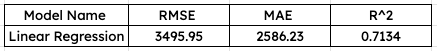

### **Confidence Intervals for the Linear Regression coefficients**

In [77]:
def confidence_interval_using_linear_regression_model(df, target_col='PremiumPrice', confidence=0.95):
    """
    Calculate regression coefficients with confidence intervals using statsmodels.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing features and target
    - target_col (str): Name of the target column (default 'PremiumPrice')
    - confidence (float): Confidence level for intervals (default 0.95)

    Returns:
    - pd.DataFrame: DataFrame with coefficients, p-values, and confidence intervals
    """
    # Prepare data (automatically drops NA values)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Add constant and fit model
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    # Get confidence intervals
    conf_int = model.conf_int(alpha=1-confidence)
    conf_int.columns = ['CI Lower', 'CI Upper']

    # Create summary dataframe
    results = pd.DataFrame({
        'Coefficient': model.params,
        'Std Error': model.bse,
        'P-value': model.pvalues,
        'CI Lower': conf_int['CI Lower'],
        'CI Upper': conf_int['CI Upper']
    })

    # Calculate relative importance (absolute coefficient * mean feature value)
    feature_importance = np.abs(model.params[1:]) * X.mean()
    results['Relative Importance'] = feature_importance.reindex(results.index).fillna(0)
    return results.sort_values('Relative Importance', ascending=False)

confidence_interval_using_linear_regression_model(df)

,Coefficient,Std Error,P-value,CI Lower,CI Upper,Relative Importance
Age,329.367129,9.839493,3.581406e-164,310.058108,348.676150,13749.574440
Weight,69.675328,8.427673,4.446604e-16,53.136861,86.213794,5361.537663
Height,-5.821878,11.919348,6.253485e-01,-29.212407,17.568650,979.138402
AnyChronicDiseases,2654.886425,313.989863,1.005973e-16,2038.712701,3271.060149,479.279699
AnyTransplants,7894.201264,521.962715,1.401348e-46,6869.901604,8918.500925,440.345912
NumberOfMajorSurgeries,-654.186239,186.103189,4.596674e-04,-1019.395147,-288.977331,436.566476
HistoryOfCancerInFamily,2311.829368,385.373495,2.796179e-09,1555.572400,3068.086337,271.979926
Diabetes,-429.119839,251.419349,8.817965e-02,-922.505184,64.265506,180.178107
BloodPressureProblems,180.503577,252.420552,4.747242e-01,-314.846528,675.853683,84.576727
KnownAllergies,300.882400,295.795564,3.093120e-01,-279.586831,881.351631,64.692768


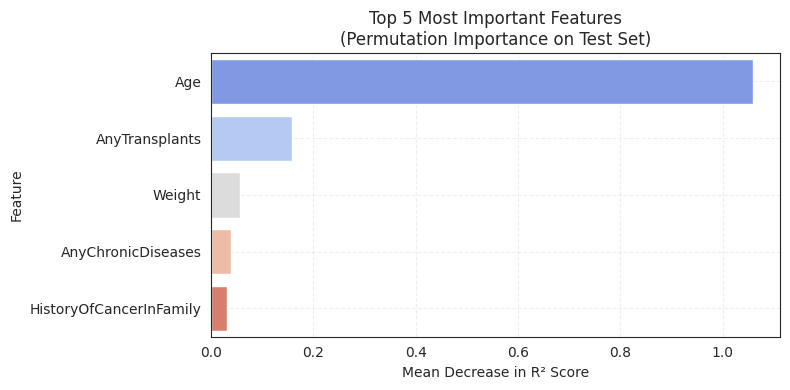

In [78]:
def feature_importance_using_linear_regression_model(df,
                                                     target_col='PremiumPrice',
                                                     top_n=None, random_state=10, figsize=(8, 4)):
    """
    Computes and visualizes permutation importance for a Linear Regression model.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with features and target
    - target_col (str): Name of the target column (default 'PremiumPrice')
    - top_n (int): Number of top features to display (default: show all)
    - random_state (int): Random seed for reproducibility
    - figsize (tuple): Figure size for the plot

    Returns:
    - pd.DataFrame: Feature importance scores and standard deviations
    """
    # Data preparation
    X = df.drop(columns=[target_col]).dropna()
    y = df[target_col].loc[X.index]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Fit model
    model = LinearRegression().fit(X_train, y_train)

    # Compute permutation importance
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        scoring='r2',
        n_jobs=-1  # Use all available cores
    )

    # Create results dataframe
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values('importance_mean', ascending=False)

    # Filter top features if specified
    if top_n:
        importance_df = importance_df.head(top_n)

    # Plotting
    plt.figure(figsize=figsize)
    sns.barplot(
        data=importance_df,
        x='importance_mean',
        y='feature',
        palette='coolwarm',
        orient='h',
        hue='feature',
        legend=False
    )

    plt.title(f'Top {top_n if top_n else len(X.columns)} Most Important Features\n'
              '(Permutation Importance on Test Set)')
    plt.xlabel('Mean Decrease in R² Score')
    plt.ylabel('Feature')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return None

feature_importance_using_linear_regression_model(df, top_n=5)

**Feature Importance Insights:**

`Age` is by far the most influential predictor of premium price, followed by `AnyTransplants`, while `Weight`, `AnyChronicDiseases`, and `HistoryOfCancerInFamily` have comparatively smaller but still notable impacts.

# **Tree based models**

####Tree-based models are machine learning algorithms that make predictions by splitting data into branches based on feature values, forming a decision tree structure.

#### **Note** : **Scaling for tree-based models like DecisionTreeRegressor, RandomForestRegressor, or GradientBoostingRegressor.**

#### **These models split data based on feature thresholds (e.g., BMI > 30) rather than using distances or gradient magnitudes that are affected by feature scales. Because of this, scaling or normalization has little to no effect on their performance.**

## **Decision Tree Model**

#### A Decision Tree is a machine learning model that predicts outcomes by recursively splitting data into subsets based on feature values, forming a tree-like structure of decisions.


In [79]:
def decision_tree_model(df, target_col='PremiumPrice', test_size=0.2, random_state=42):
    """
    Optimizes and evaluates a Decision Tree Regressor with hyperparameter tuning.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with features and target
    - target_col (str): Name of the target column (default 'PremiumPrice')
    - test_size (float): Proportion for test split (default 0.2)
    - random_state (int): Random seed for reproducibility (default 42)

    Returns:
    - best_model: Optimized DecisionTreeRegressor
    - metrics: Dictionary of evaluation metrics
    """
    # Split data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Corrected parameter grid
    param_grid = {
        'max_depth': [None, 3, 5, 7, 10, 15],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': [None, 'sqrt', 'log2']  # Removed invalid 'auto' option
    }

    # Grid search with improved error handling
    grid_search = GridSearchCV(
        DecisionTreeRegressor(random_state=random_state),
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        error_score='raise'  # Will raise errors immediately for debugging
    )

    print("Optimizing decision tree hyperparameters...")
    grid_search.fit(X_train, y_train)

    # Get best model and predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    metrics = {
        'best_params': grid_search.best_params_,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'cv_rmse': np.sqrt(-grid_search.best_score_)
    }

    # Print results
    print("\n=== Decision Tree Evaluation ===")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"Cross-Validated RMSE: {metrics['cv_rmse']:.2f}")
    print(f"Test RMSE: {metrics['rmse']:.2f}")
    print(f"Test MAE: {metrics['mae']:.2f}")
    print(f"Test R²: {metrics['r2']:.4f}")

    return best_model, metrics



In [80]:
# Decision Tree model without Feature Engineering and Scaling
best_decision_tree_model, best_decision_tree_metrics = decision_tree_model(df)

Optimizing decision tree hyperparameters...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

=== Decision Tree Evaluation ===
Best Parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
Cross-Validated RMSE: 3034.22
Test RMSE: 2177.71
Test MAE: 1044.65
Test R²: 0.8888


In [81]:
# Decision Tree model with Feature Engineering and Scaling
best_decision_tree_model_with_bmi, best_decision_tree_metrics_with_bmi = decision_tree_model(df_scaled)

Optimizing decision tree hyperparameters...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

=== Decision Tree Evaluation ===
Best Parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
Cross-Validated RMSE: 3437.82
Test RMSE: 2692.13
Test MAE: 1665.29
Test R²: 0.8300


#### **Note** : Feature Enginnering and Scaling is decreasing performance.

#### **Decision Trees Insights:**

* The Decision Tree model explains **88.88%** of the variance in the target, indicating a strong fit.
* Low Test RMSE (**2177.71**) and MAE (**1044.65**) suggest high accuracy and small average prediction errors.
* The model generalizes well, with cross-validated RMSE close to the test RMSE.


### Performance Metrics

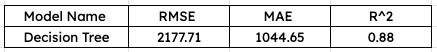



In [82]:
def feature_importance_using_decision_trees_model(df, target_col='PremiumPrice',
                                 n_iterations=1000, ci=0.95, random_state=42, **tree_params):
    """
    Estimate confidence intervals for Decision Tree feature importance using bootstrapping.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with features and target
    - target_col (str): Name of the target column
    - n_iterations (int): Number of bootstrap samples
    - ci (float): Confidence level (0-1)
    - random_state (int): Random seed for reproducibility
    - tree_params (dict): Parameters to pass to DecisionTreeRegressor

    Returns:
    - pd.DataFrame: Feature importance with confidence intervals
    """
    # Prepare data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    feature_names = X.columns

    # Initialize results storage
    importances = np.zeros((n_iterations, len(feature_names)))
    model = DecisionTreeRegressor(random_state=random_state, **tree_params)

    # Bootstrap sampling
    for i in range(n_iterations):
        X_sample, y_sample = resample(X, y, random_state=random_state+i)
        model.fit(X_sample, y_sample)
        importances[i] = model.feature_importances_

    # Calculate statistics
    alpha = (1 - ci) / 2
    lower = np.percentile(importances, alpha * 100, axis=0)
    upper = np.percentile(importances, (1 - alpha) * 100, axis=0)
    mean = importances.mean(axis=0)

    # Create results DataFrame
    results = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': mean,
        f'ci_lower_{ci:.0%}': lower,
        f'ci_upper_{ci:.0%}': upper,
        'importance_std': importances.std(axis=0)
    }).sort_values('importance_mean', ascending=False)

    return results.reset_index(drop=True)

feature_importance_using_decision_trees_model(df)

,feature,importance_mean,ci_lower_95%,ci_upper_95%,importance_std
0,Age,0.648310,0.580903,0.704597,0.032470
1,AnyTransplants,0.102324,0.066447,0.140428,0.019161
2,Weight,0.100501,0.061896,0.150387,0.023145
3,NumberOfMajorSurgeries,0.037908,0.021329,0.061314,0.010062
4,Height,0.036761,0.009082,0.078704,0.018516
5,AnyChronicDiseases,0.034062,0.017834,0.057047,0.010188
6,HistoryOfCancerInFamily,0.022552,0.011745,0.037006,0.006386
7,BloodPressureProblems,0.007856,0.000017,0.025799,0.007095
8,Diabetes,0.006212,0.000000,0.022426,0.006198
9,KnownAllergies,0.003514,0.000000,0.017434,0.004639


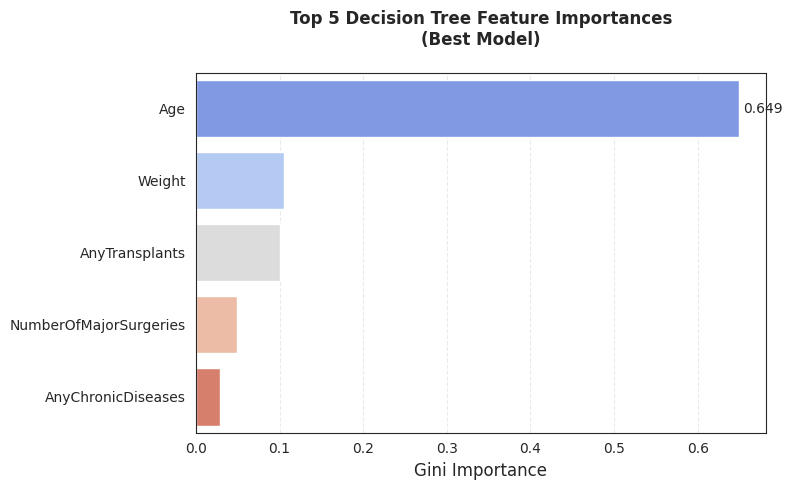

In [83]:
def plot_decision_tree_importance(df, target_col='PremiumPrice', top_n=5,
                                figsize=(8, 5), random_state=42, **best_params):
    """
    Visualizes feature importance from Decision Tree using best hyperparameters.

    Parameters:
    - df (pd.DataFrame): Input data
    - target_col (str): Target column name
    - top_n (int): Number of top features to show
    - figsize (tuple): Figure dimensions
    - random_state (int): Random seed
    - best_params (dict): Optimal parameters from grid search

    Returns:
    - pd.DataFrame: Feature importance scores
    """
    # Prepare data
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train model with best parameters
    model = DecisionTreeRegressor(random_state=random_state, **best_params)
    model.fit(X, y)

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=importance_df,
        x='importance',
        y='feature',
        hue='feature',
        palette='coolwarm',
        orient='h',
        legend=False
    )

    plt.title(f'Top {top_n} Decision Tree Feature Importances\n(Best Model)',
              fontweight='bold', pad=20)
    plt.xlabel('Gini Importance', fontsize=12)
    plt.ylabel('')
    ax.bar_label(ax.containers[0], fmt='%.3f', padding=3)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    return None

plot_decision_tree_importance(df, top_n=5)

#### **Feature Importance Insights:**
Age is the most influential feature in the Decision Tree model, contributing far more to predictions than Weight, AnyTransplants, NumberOfMajorSurgeries, and AnyChronicDiseases.


## **Random Forest Model**

#### A Random Forest model is an ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting.

In [84]:
def random_forest_model(df, target_col='PremiumPrice', test_size=0.2, cv=5, random_state=42):
    """
    Evaluates and tunes a RandomForestRegressor using GridSearchCV and K-Fold cross-validation.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing features and target.
    - target_col (str): Name of the target column.
    - test_size (float): Size of the test set.
    - cv (int): Number of folds for cross-validation.
    - random_state (int): Seed for reproducibility.

    Returns:
    - tuple: (best_model, evaluation_metrics)
    """
    # 1. Prepare data with train-test split
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 2. Define the model and parameter grid
    model = RandomForestRegressor(random_state=random_state)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }

    # 3. Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=KFold(n_splits=cv, shuffle=True, random_state=random_state),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    # 4. Fit on training data only
    print("\n--- Starting GridSearchCV for Random Forest ---")
    grid_search.fit(X_train, y_train)

    # 5. Get the best model
    best_model = grid_search.best_estimator_

    # 6. Evaluate on both train and test sets
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    # Calculate metrics
    metrics = {
        'best_params': grid_search.best_params_,
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'test_r2': r2_score(y_test, test_pred),
        'cv_rmse': np.sqrt(-grid_search.best_score_)
    }

    # 7. Print results
    print("\n=== Random Forest Evaluation ===")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"CV RMSE: {metrics['cv_rmse']:.2f}")
    print(f"Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Test MAE: {metrics['test_mae']:.2f}")
    print(f"Test R²: {metrics['test_r2']:.4f}")

    return best_model, metrics



In [85]:
# Random Forest model without Feature Engineering and Scaling
best_random_forest_model, best_random_forest_metrics = random_forest_model(df)


--- Starting GridSearchCV for Random Forest ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

=== Random Forest Evaluation ===
Best Parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
CV RMSE: 2979.44
Test RMSE: 2071.14
Test MAE: 992.53
Test R²: 0.8994


In [86]:
# Random Forest model without Feature Engineering and Scaling
best_random_forest_model_with_bmi, best_random_forest_metrics_bmi = random_forest_model(df_scaled)


--- Starting GridSearchCV for Random Forest ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

=== Random Forest Evaluation ===
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
CV RMSE: 3311.00
Test RMSE: 2360.20
Test MAE: 1443.45
Test R²: 0.8694


#### **Note** : Feature Enginnering and Scaling is decreasing performance.

#### **Random Forest Insights:**

* The Random Forest model explains **89.94%** of the variance in the target on the test set, showing strong predictive power.
* Test RMSE (**2071.14**) is low, indicating accurate predictions and minimal overfitting compared to train performance.
* The model generalizes well, with CV RMSE close to test RMSE.

### **Performance Metrics**

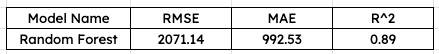

In [87]:
def confidence_interval_using_random_forest_model(df,
                                                  target_col='PremiumPrice', n_iterations=100, random_state=42,
                                                  max_depth=15, min_samples_split=10, n_estimators=200):
    """
    Calculate 95% confidence intervals for feature importance using bootstrapping.

    Parameters:
    - df: Input DataFrame
    - target_col: Target column name
    - n_iterations: Number of bootstrap samples (default 100)
    - random_state: Random seed
    - RF parameters: max_depth, min_samples_split, n_estimators

    Returns:
    - DataFrame with feature, mean importance, and 95% CI bounds
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    features = X.columns

    # Store all importance values
    all_importances = []

    # Perform bootstrapping
    for i in range(n_iterations):
        # Resample data
        X_sample, y_sample = resample(X, y, random_state=random_state+i)

        # Train model with fixed parameters
        model = RandomForestRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            n_estimators=n_estimators,
            random_state=random_state+i
        )
        model.fit(X_sample, y_sample)
        all_importances.append(model.feature_importances_)

    # Convert to numpy array
    all_importances = np.array(all_importances)

    # Calculate statistics
    results = pd.DataFrame({
        'feature': features,
        'mean_importance': np.mean(all_importances, axis=0),
        'ci_lower': np.percentile(all_importances, 2.5, axis=0),
        'ci_upper': np.percentile(all_importances, 97.5, axis=0)
    })

    return results.sort_values('mean_importance', ascending=False)


confidence_interval_using_random_forest_model(df)

,feature,mean_importance,ci_lower,ci_upper
0,Age,0.681608,0.623870,0.731969
3,AnyTransplants,0.108280,0.074235,0.145024
6,Weight,0.089063,0.067852,0.123530
4,AnyChronicDiseases,0.038591,0.023551,0.066842
9,NumberOfMajorSurgeries,0.029723,0.018210,0.042827
8,HistoryOfCancerInFamily,0.023024,0.014660,0.034744
5,Height,0.022172,0.010196,0.041105
2,BloodPressureProblems,0.004913,0.000782,0.015431
1,Diabetes,0.001726,0.000531,0.004040
7,KnownAllergies,0.000900,0.000267,0.002311


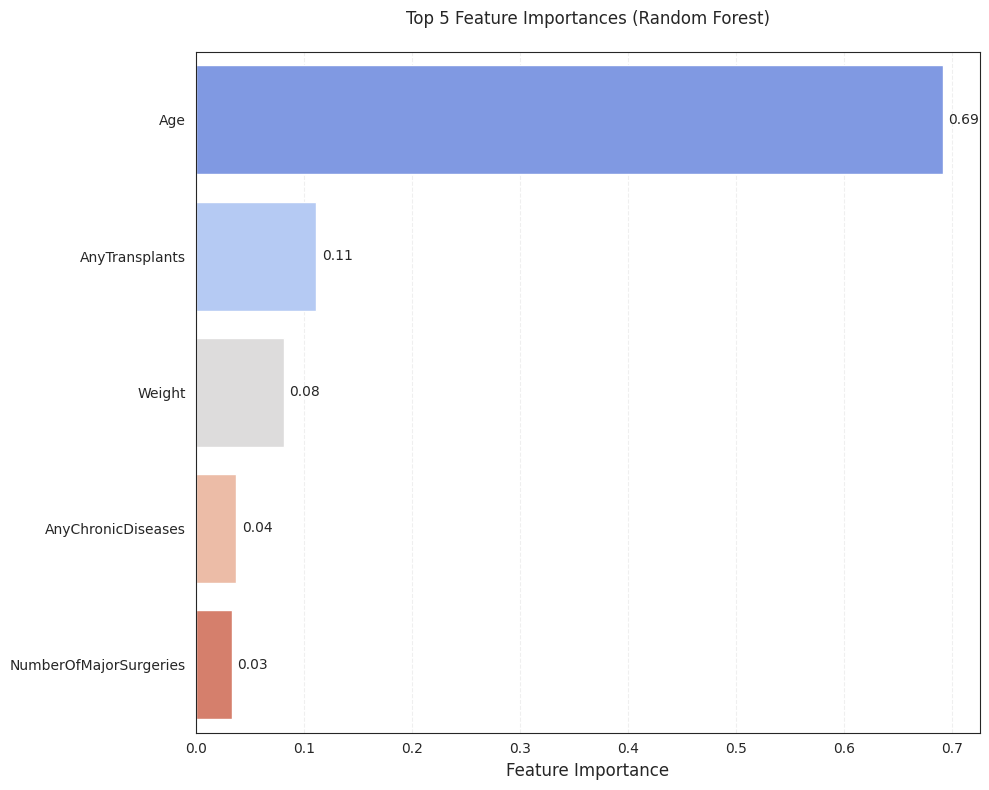

In [88]:
def feature_importance_using_random_forest_model(df,
                                                 target_col='PremiumPrice', top_n=5,
                                                 random_state=42, figsize=(10, 8)):
    """
    Plots feature importance from Random Forest with best hyperparameters.

    Parameters:
    - df: Input DataFrame
    - target_col: Target column name
    - top_n: Number of top features to display
    - random_state: Random seed
    - figsize: Figure dimensions

    Returns:
    - DataFrame of feature importances
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Best parameters from your tuning
    best_params = {
        'max_depth': 15,
        'min_samples_split': 10,
        'n_estimators': 200,
        'random_state': random_state,
        'n_jobs': -1
    }

    # Train model
    model = RandomForestRegressor(**best_params)
    model.fit(X, y)

    # Get importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=importance_df,
        x='Importance',
        y='Feature',
        hue='Feature',
        palette='coolwarm',
        orient='h',
        legend=False
    )

    # Add value labels
    for i, (_, row) in enumerate(importance_df.iterrows()):
        ax.text(row['Importance'] + 0.005, i,
                f"{row['Importance']:.2f}",
                va='center')

    plt.title(f'Top {top_n} Feature Importances (Random Forest)',
             fontsize=12, pad=20)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('')
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    return None

# Example usage
feature_importance_using_random_forest_model(df, top_n=5)

#### **Random Forest Insights:**

Age is the dominant predictor in the Random Forest model, followed by AnyTransplants and Weight, while features like Height and HistoryOfCancerInFamily have minimal impact.


# **Gradient Boosting**

#### Gradient Boosting is an ensemble learning method that builds decision trees sequentially, with each new tree correcting the errors of the previous ones to improve overall prediction accuracy.


In [89]:
def gradient_boosting_model(df, target_col='PremiumPrice', test_size=0.2,
                          cv=5, random_state=42):
    """
    Optimizes and evaluates a Gradient Boosting model with hyperparameter tuning.

    Parameters:
    - df: Input DataFrame
    - target_col: Target column name
    - test_size: Size of test set
    - cv: Number of cross-validation folds
    - random_state: Random seed

    Returns:
    - tuple: (best_model, evaluation_metrics)
    """
    # Split data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'min_samples_split': [2, 5]
    }

    # Grid search
    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=random_state),
        param_grid,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    print("Optimizing Gradient Boosting hyperparameters...")
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Evaluate
    test_pred = best_model.predict(X_test)
    train_pred = best_model.predict(X_train)

    metrics = {
        'best_params': grid_search.best_params_,
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'test_r2': r2_score(y_test, test_pred),
        'cv_rmse': np.sqrt(-grid_search.best_score_)
    }

    print("\n=== Gradient Boosting Evaluation ===")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"CV RMSE: {metrics['cv_rmse']:.2f}")
    print(f"Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Test MAE: {metrics['test_mae']:.2f}")
    print(f"Test R²: {metrics['test_r2']:.4f}")

    return best_model, metrics



In [90]:
# Random Forest model without Feature Engineering and Scaling
best_gradient_boost_model, best_gradient_boost_metrics = gradient_boosting_model(df)

Optimizing Gradient Boosting hyperparameters...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

=== Gradient Boosting Evaluation ===
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
CV RMSE: 3075.41
Test RMSE: 2386.98
Test MAE: 1551.38
Test R²: 0.8664


In [91]:
# Random Forest model with Feature Engineering and Scaling
best_gradient_boost_model_with_bmi, best_gradient_boost_metrics_bmi = gradient_boosting_model(df_scaled)

Optimizing Gradient Boosting hyperparameters...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

=== Gradient Boosting Evaluation ===
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
CV RMSE: 3377.97
Test RMSE: 2556.84
Test MAE: 1796.81
Test R²: 0.8467


#### **Note** : Feature Engineering and Scaling is decreasing performance.

### **Gradient Boosting Model Insights**

* The Gradient Boosting model explains **86.64%** of the variance on the test set, showing strong predictive capability.
* Test RMSE (**2386.98**) is reasonably close to train RMSE, indicating good generalization with minimal overfitting.
* The cross-validation score is consistent with test performance, suggesting stable results.




### **Performance Metrics**

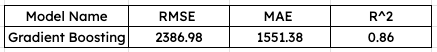

In [92]:
def confidence_interval_using_gradient_boost_model(df, target_col='PremiumPrice', n_iterations=100, ci=95, random_state=42):
    """
    Complete workflow that:
    1. Trains a Gradient Boosting model
    2. Calculates feature importance confidence intervals

    Parameters:
    - df: Input DataFrame
    - target_col: Target column name
    - n_iterations: Bootstrap iterations (default 100)
    - ci: Confidence level (default 95)
    - random_state: Random seed

    Returns:
    - DataFrame with feature importance and CIs
    - Trained model
    """
    # 1. Prepare data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # 2. Train model with your best parameters
    best_params = {
        'learning_rate': 0.05,
        'max_depth': 3,
        'min_samples_split': 2,
        'n_estimators': 100,
        'subsample': 0.8,
        'random_state': random_state
    }

    model = GradientBoostingRegressor(**best_params)
    model.fit(X_train, y_train)

    # 3. Calculate confidence intervals
    feature_importances = np.zeros((n_iterations, X_train.shape[1]))
    rng = np.random.RandomState(random_state)

    for i in range(n_iterations):
        indices = rng.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        X_sample = X_train.iloc[indices]
        y_sample = model.predict(X_sample)  # Use model's predictions

        temp_model = GradientBoostingRegressor(**best_params)
        temp_model.fit(X_sample, y_sample)
        feature_importances[i] = temp_model.feature_importances_

    # Calculate statistics
    lower = np.percentile(feature_importances, (100-ci)/2, axis=0)
    upper = np.percentile(feature_importances, 100-(100-ci)/2, axis=0)

    ci_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importances.mean(axis=0),
        f'ci_lower_{ci}%': lower,
        f'ci_upper_{ci}%': upper
    }).sort_values('importance', ascending=False)

    return ci_df


confidence_interval_using_gradient_boost_model(df)

,feature,importance,ci_lower_95%,ci_upper_95%
0,Age,0.772221,0.732258,0.809162
3,AnyTransplants,0.111282,0.076775,0.142617
6,Weight,0.053735,0.040007,0.067013
4,AnyChronicDiseases,0.037016,0.022275,0.057796
9,NumberOfMajorSurgeries,0.011628,0.006799,0.016659
8,HistoryOfCancerInFamily,0.009206,0.005932,0.013807
5,Height,0.003310,0.000977,0.006971
2,BloodPressureProblems,0.001460,0.000670,0.002598
7,KnownAllergies,0.000103,0.000000,0.000718
1,Diabetes,0.000039,0.000000,0.000397


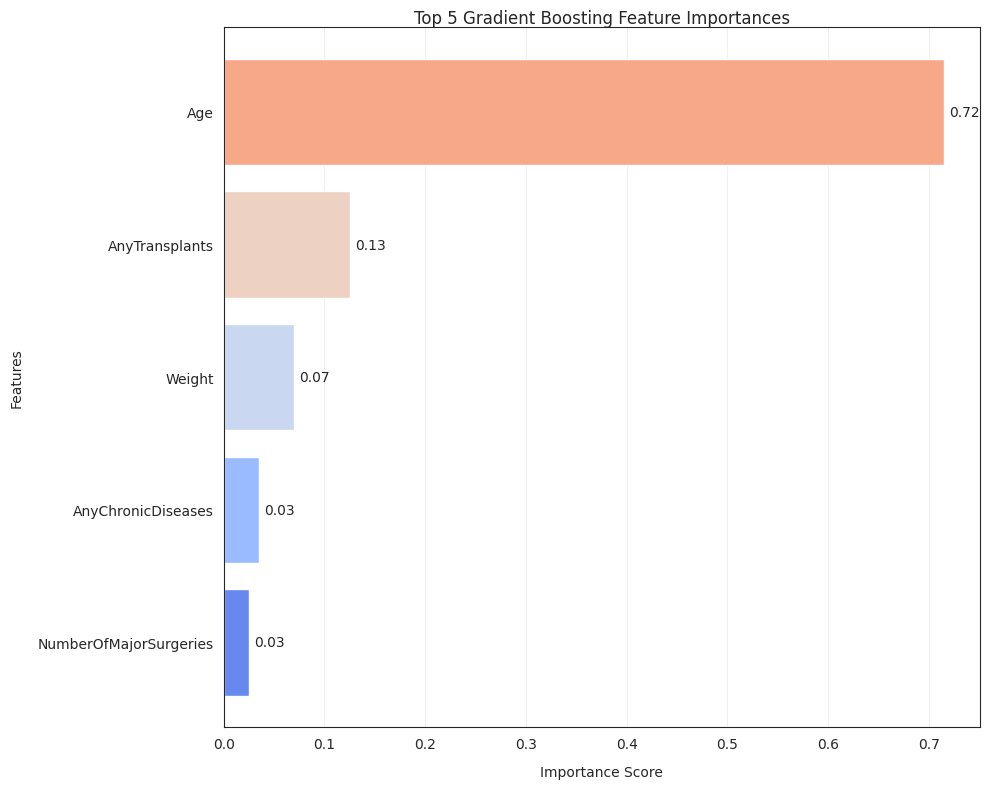

In [93]:
def feature_importance_using_gradient_boost_model(df, target_col='PremiumPrice', top_n=5, figsize=(10, 8)):
    """
    Simple function to plot Gradient Boosting feature importance
    with descending order and coolwarm palette

    Parameters:
    - df: Input DataFrame
    - target_col: Target column name
    - top_n: Number of top features to show
    - figsize: Figure size
    """
    # Train model with best parameters
    model = GradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=2,
        n_estimators=100,
        subsample=0.8,
        random_state=42
    )
    X = df.drop(columns=[target_col])
    y = df[target_col]
    model.fit(X, y)

    # Get and sort feature importances
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(top_n)  # Sort ascending first

    # Create color palette
    colors = sns.color_palette("coolwarm")

    # Create plot
    plt.figure(figsize=figsize)
    bars = plt.barh(importance['Feature'], importance['Importance'], color=colors)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}',
                va='center',
                fontsize=10)

    plt.title(f'Top {top_n} Gradient Boosting Feature Importances', pad=0)
    plt.xlabel('Importance Score', labelpad=10)
    plt.ylabel('Features', labelpad=10)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
feature_importance_using_gradient_boost_model(df)

#### **Feature Importance Insight:**

Age is by far the most important feature in the Gradient Boosting model, followed by AnyTransplants, while Weight, AnyChronicDiseases, and NumberOfMajorSurgeries contribute much less.


# **Neural Networks**

#### A neural network is a machine learning model inspired by the human brain, consisting of interconnected layers of nodes (neurons) that learn patterns from data to make predictions or classifications.


In [94]:
def neural_network_model(df, target_col='PremiumPrice', random_state=42):
    """
    Clean neural network implementation without warnings.
    Uses fixed architecture with only learning rate tuning.

    Parameters:
    - df: Input DataFrame
    - target_col: Target column name
    - random_state: Random seed

    Returns:
    - Trained neural network model
    """
    # 1. Prepare data
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 2. Stable model architecture
    def create_model(learning_rate=0.01):
        model = Sequential([
            Input(shape=(X_train_scaled.shape[1],)),  # Explicit input layer
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='mse'
        )
        return model

    # 3. Minimal hyperparameter search
    param_grid = {
        'model__learning_rate': [0.001, 0.01]  # Only tune learning rate
    }

    # 4. Clean training process
    nn = KerasRegressor(
        model=create_model,
        epochs=50,
        batch_size=64,
        verbose=0,
        random_state=random_state
    )

    print("Training neural network...")
    search = GridSearchCV(  # Using GridSearch since we have few combinations
        estimator=nn,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error'
    )

    search.fit(X_train_scaled, y_train)

    # 5. Evaluation
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    print("\n=== Neural Network Results ===")
    print(f"Best Learning Rate: {search.best_params_['model__learning_rate']}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"Test MAE: {(mean_absolute_error(y_test, y_pred)):.2f}")
    print(f"Test R²: {r2_score(y_test, y_pred):.4f}")

    return best_model



In [95]:
# Neural Netowrk model without Feature Engineering and Scaling
best_neural_network_model = neural_network_model(df)

Training neural network...



=== Neural Network Results ===
Best Learning Rate: 0.01
Test RMSE: 3706.95
Test MAE: 2755.45
Test R²: 0.6778


In [96]:
# Neural Netowrk model with Feature Engineering and Scaling
best_neural_network_model_with_bmi = neural_network_model(df_scaled)

Training neural network...

=== Neural Network Results ===
Best Learning Rate: 0.01
Test RMSE: 3704.93
Test MAE: 2768.33
Test R²: 0.6781


#### **Note** : Feature Engineering and Scaling is slighly increasing model performance.

#### **Neural Network Insights:**

* The Neural Network model explains **67.78%** of the variance on the test set, which is lower than tree-based models, indicating comparatively weaker predictive performance.
* The higher Test RMSE (**3706.95**) suggests larger average prediction errors.
* Model tuning or additional feature engineering may be needed to improve performance.


### **Performance Metrics**

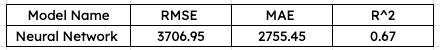

# **Summary of ML models**

### **Performance Metrics**


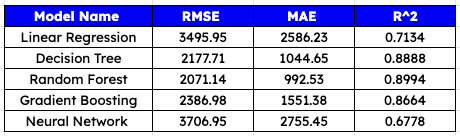

#### **Recommended Model:**

The **Random Forest** model (without Feature Engineering and Scaling) should be preferred as it has the lowest RMSE and MAE along with the highest R², indicating the best overall predictive accuracy and reliability among the compared models.


# **Web App using Streamlit**

In [97]:
# Save the trained model
joblib.dump(best_random_forest_model, "final_random_forest_model.pkl")
print("Model saved as tuned_random_forest_model.pkl")

Model saved as tuned_random_forest_model.pkl


In [98]:
## AuthToken
#!ngrok config add-authtoken <Please enter your AuthToken>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [99]:
# # Delete active sessions.

# from pyngrok import ngrok

# # Kill all active tunnels
# ngrok.kill()

# # Now start the tunnel again
# public_url = ngrok.connect(port=8501)
# print("Streamlit app running at:", public_url)


In [100]:
## Working code

!pip -q install pyngrok==7 streamlit
from pyngrok import ngrok
public_url = ngrok.connect(8501, "http")
print(public_url)

# In another cell, start Streamlit
import subprocess, os
os.environ["STREAMLIT_SERVER_HEADLESS"] = "true"
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "0.0.0.0"])


NgrokTunnel: "https://9a635ccc999c.ngrok-free.app" -> "http://localhost:8501"


<Popen: returncode: None args: ['streamlit', 'run', 'app.py', '--server.port...>

### **Web App output (Age 20):**

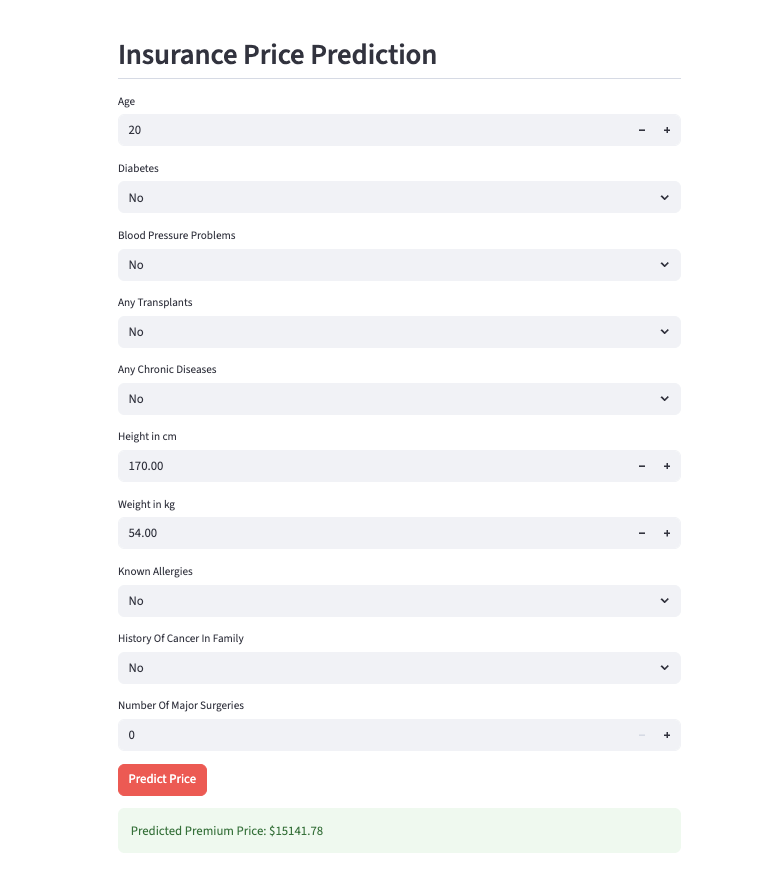

**Web App Output (Age 50):**

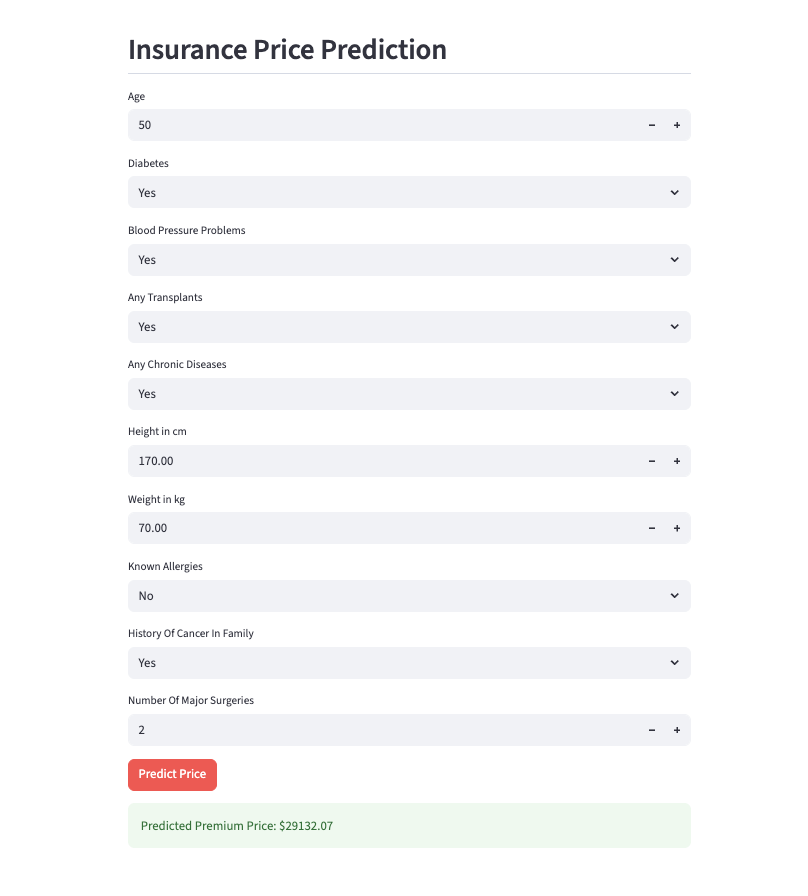

**Web App Output (Age 66)**

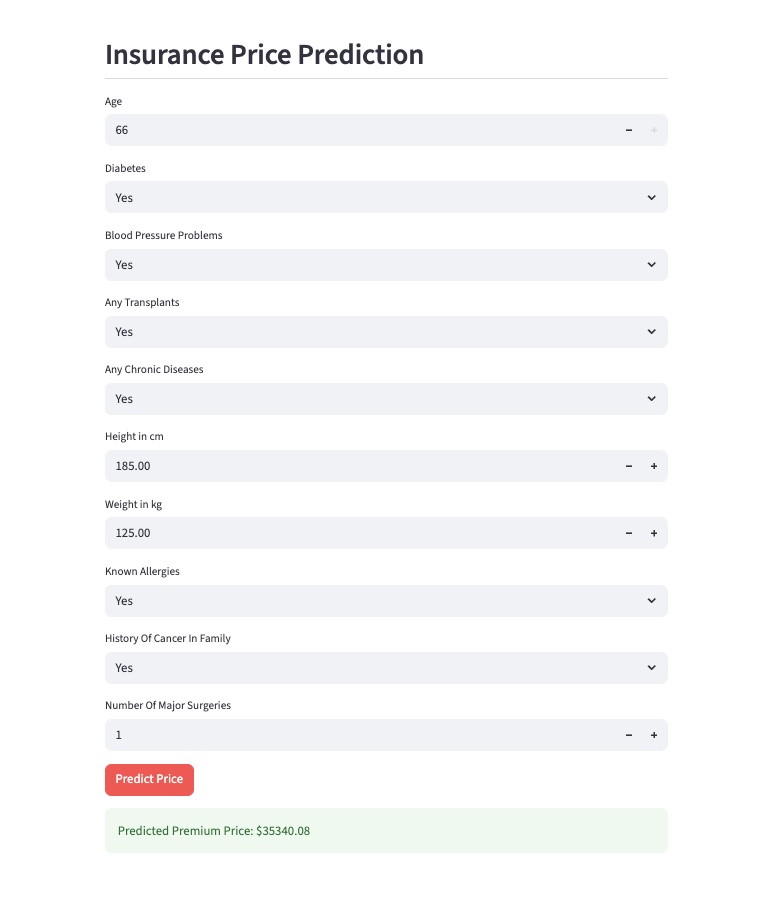

### **Project Insights: Insurance Premium Prediction**

#### **1. Key Drivers of Premium Price**

**Age** is the most significant factor influencing premium prices, with the **highest correlation ($0.70$)** to the target `PremiumPrice` and the **highest feature importance** in both Random Forest and Gradient Boosting models. Additionally, medical attributes such as `AnyTransplants`, `Chronic Diseases`, and `Number of Major Surgeries` also contribute significantly to the premium value.


#### **2. Model Performance Comparison**

The **Random Forest** model emerged as the top performer, achieving the lowest **RMSE ($2071$)** and **MAE ($993$)** and the highest **$R^{2}$ ($0.899$)**. This model provides the most accurate, stable, and interpretable predictions without requiring additional feature engineering or scaling.

| Model | RMSE | MAE | $R^{2}$ |
| :--- | :--- | :--- | :--- |
| **Random Forest** | **2071** | **993** | **0.899** |
| Decision Tree | 2178 | 1045 | 0.889 |
| Gradient Boosting | 2387 | 1551 | 0.866 |
| Linear Regression | 3496 | 2586 | 0.713 |
| Neural Network | 3707 | 2755 | 0.678 |


#### **3. Web Application Usability & Design**

The web application is designed for a non-technical audience with a simple and intuitive user interface. Key features include a **real-time calculator** for interactive premium estimation and **automatic BMI calculation** from height and weight inputs. The use of a numerical input box for age and a dropdown menu for surgeries enhances data precision and reduces input errors. These features make the application user-friendly and effective.

### **Recommendations for the Insurance Company**

#### **A. Personalized Pricing Model**

* Implement a model to provide **real-time premium quotes** based on a user’s medical information.
* Integrate this model into customer portals and agent dashboards for easy access.


#### **B. Age-Based Segmentation**

* Analyze the trend that customers above a certain **age threshold (e.g., > 50)** have a sharp increase in predicted premiums.
* Develop **age-specific products or discounts** to remain competitive in the market.


#### **C. Enhanced Data Collection**

* Encourage applicants to provide accurate **height and weight** data to improve BMI calculations.
* Consider collecting additional **lifestyle factors** (e.g., smoker status, physical activity) in future versions to enhance prediction accuracy.


#### **D. Model Maintenance**

* Retrain the model **annually** using new customer and claims data.
* Monitor **model drift**, particularly in response to changes in medical practices or premium structures.


#### **E. Future Enhancements**

* Incorporate **SHAP explanations** into the application to increase customer trust and transparency.
* Add **multilingual support** to better serve regional user bases.
* Develop a **mobile-friendly version** of the application for wider accessibility.